In [1]:
import wrangle as w
import wrangle_Naomi
import env

import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from importlib import reload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
reload(w)
df = w.wrangle_zillow()

In [3]:
train, validate, test = w.tvt_split(df)

In [4]:
print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (24203, 38)
validate observations:  (10374, 38)
test observations:  (8645, 38)


In [5]:
train.log_error.isnull().sum()

0

# explore

### Does having nice outdoor features have a relationship with logerror?

### Unscaled

In [6]:
train.head()

,Unnamed: 0,parcel_id,bath_count,bed_count,calc_bath_and_bed,calc_sqft,finished_sqft12,fips,fireplace_count,full_bath_count,...,tax_amount,census_tract_and_block,log_error,transaction_date,heating_system_desc,property_land_use_desc,log_error_outliers,outliers,bound_group,true_error
33204,29306,12716502,1.0,3,1.0,1212,1212.0,6037,0,1.0,...,1189.69,6.037503e+13,-0.037731,2017-04-25,Floor/Wall,Single Family Residential,NaN,lower,in,0.916789
18849,20531,12691266,3.0,3,3.0,2212,2212.0,6037,0,3.0,...,15618.09,6.037670e+13,-0.029250,2017-03-28,Central,Single Family Residential,NaN,lower,in,0.934867
38808,19251,11445692,1.0,2,1.0,839,839.0,6037,0,1.0,...,2637.27,6.037650e+13,0.004710,2017-03-23,Floor/Wall,Single Family Residential,NaN,in_range,in,1.010904
4851,46624,13078107,2.0,3,2.0,1136,1136.0,6037,0,2.0,...,4234.21,6.037403e+13,-0.033041,2017-06-15,Central,Condominium,NaN,lower,in,0.926741
35002,57700,11106522,1.0,1,1.0,635,635.0,6037,0,1.0,...,1563.15,6.037920e+13,0.052033,2017-07-18,Central,Condominium,NaN,upper,in,1.127283


In [7]:
X3 = train[['garage_car_count', 'pool_count', 'lot_sqft']]

In [8]:
kmeans = KMeans(n_clusters = 4).fit(X3)
train['cluster3'] = kmeans.predict(X3)

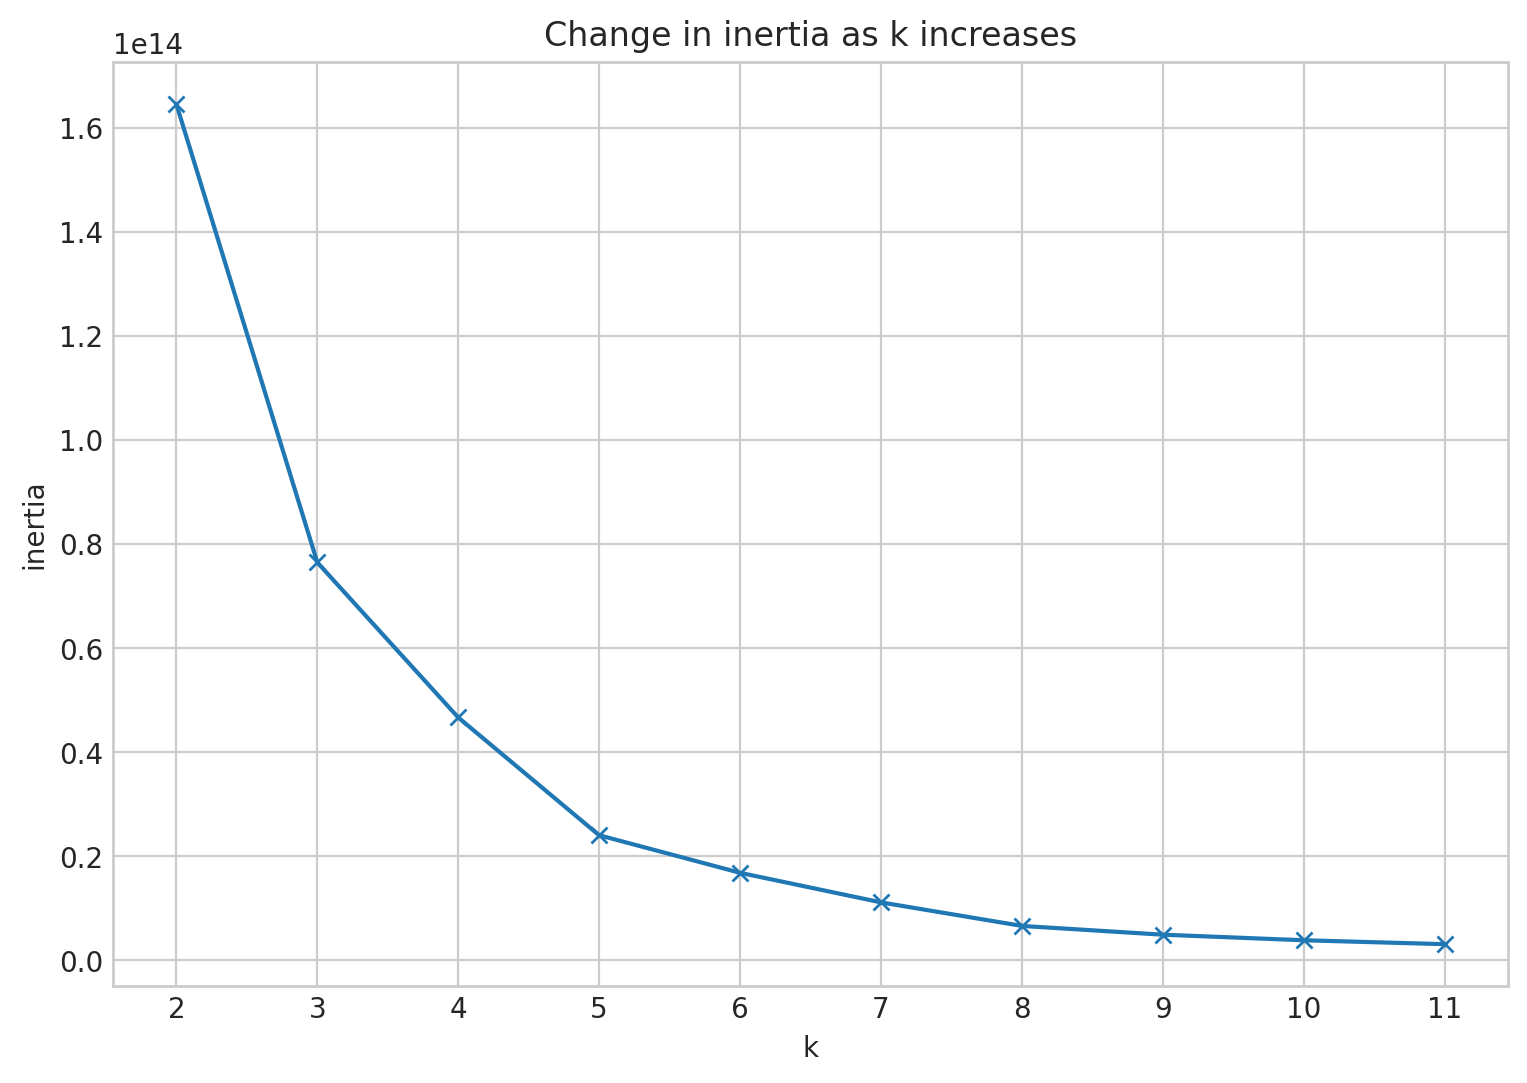

In [9]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [10]:
train.groupby('cluster3')['garage_car_count', 'pool_count', 'lot_sqft'].mean()

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/887977046.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train.groupby('cluster3')['garage_car_count', 'pool_count', 'lot_sqft'].mean()


,garage_car_count,pool_count,lot_sqft
cluster3,,,
0,0.617913,0.202027,1.416610e+04
1,0.000000,0.000000,6.971010e+06
2,0.009950,0.562189,4.107933e+05
3,0.000000,0.058824,1.967399e+06


<AxesSubplot:xlabel='cluster3', ylabel='log_error'>

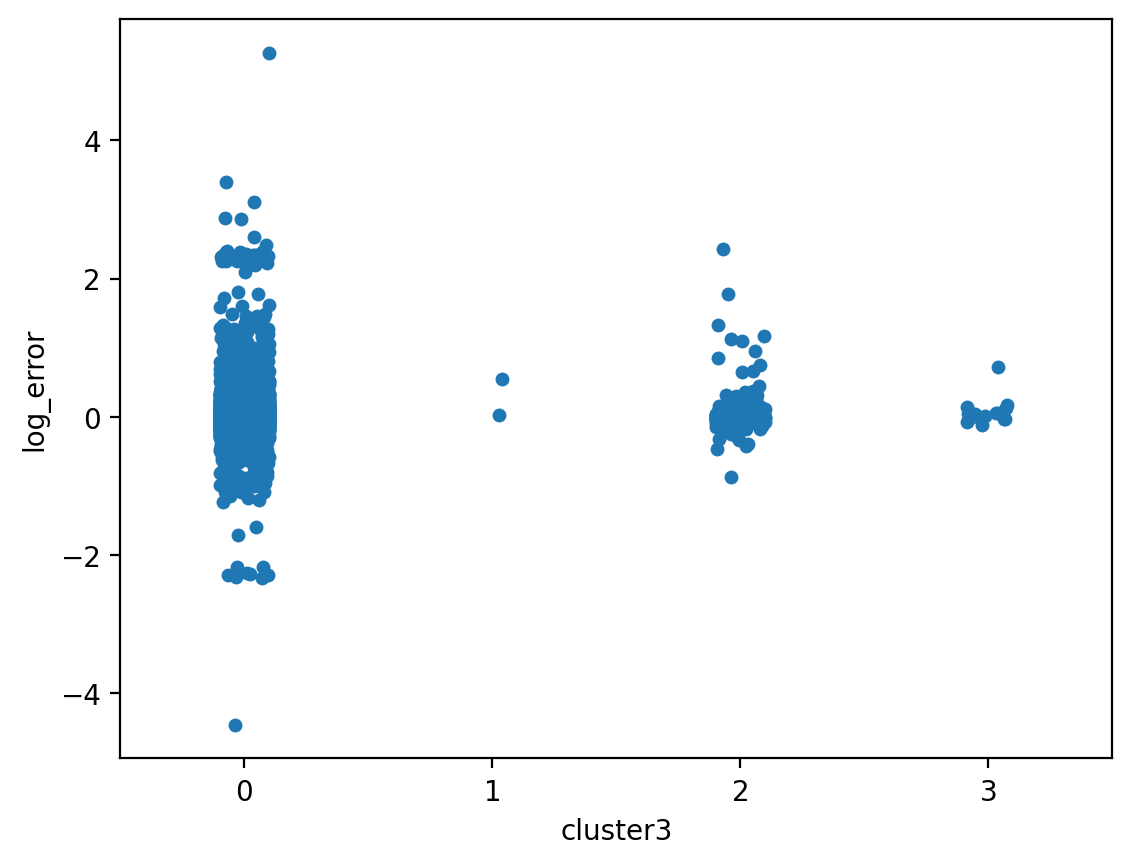

In [11]:
sns.stripplot(data = train, x = 'cluster3', y = 'log_error')

### Scaled

In [12]:
train_scaled3 = w.scale(train, ['garage_car_count', 'pool_count', 'lot_sqft'])
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
33204,0.0,0.0,0.000803
18849,0.0,0.0,0.003972
38808,0.0,0.0,0.000789
4851,0.0,0.0,0.002358
35002,0.0,1.0,0.027053


In [13]:
extracted_col = train['log_error']

In [14]:
X3_scaled = train_scaled3[['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft']]

In [15]:
X3_scaled.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
33204,0.0,0.0,0.000803
18849,0.0,0.0,0.003972
38808,0.0,0.0,0.000789
4851,0.0,0.0,0.002358
35002,0.0,1.0,0.027053


In [16]:
kmeans = KMeans(n_clusters = 4).fit(X3_scaled)
train_scaled3['cluster3_scaled'] = kmeans.predict(X3_scaled)

In [17]:
train_scaled3['log_error'] = train['log_error']

In [18]:
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft,cluster3_scaled,log_error
33204,0.0,0.0,0.000803,1,-0.037731
18849,0.0,0.0,0.003972,1,-0.029250
38808,0.0,0.0,0.000789,1,0.004710
4851,0.0,0.0,0.002358,1,-0.033041
35002,0.0,1.0,0.027053,0,0.052033


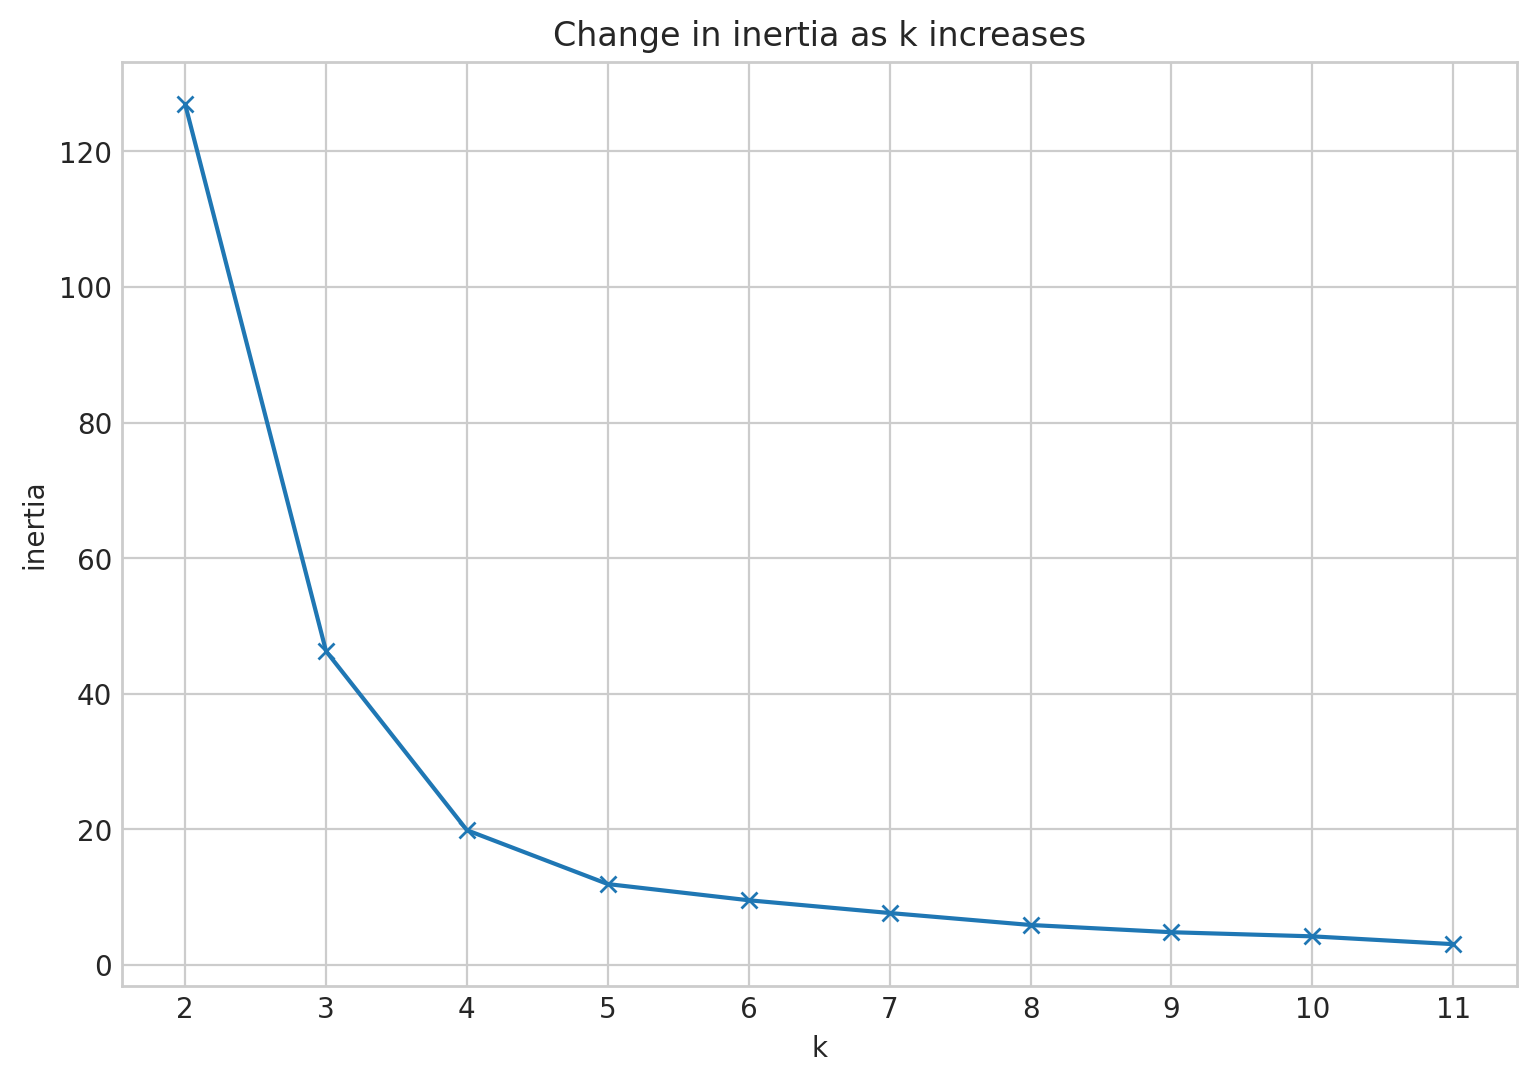

In [19]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [20]:
train_scaled3.groupby('cluster3_scaled')['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft'].mean()

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/2461689130.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_scaled3.groupby('cluster3_scaled')['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft'].mean()


,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft
cluster3_scaled,,,
0,0.002546,1.0,0.009391
1,0.000000,0.0,0.003754
2,0.136841,0.0,0.000743
3,0.168903,1.0,0.001795


In [21]:
train_scaled3.head()

,scaled_garage_car_count,scaled_pool_count,scaled_lot_sqft,cluster3_scaled,log_error
33204,0.0,0.0,0.000803,1,-0.037731
18849,0.0,0.0,0.003972,1,-0.029250
38808,0.0,0.0,0.000789,1,0.004710
4851,0.0,0.0,0.002358,1,-0.033041
35002,0.0,1.0,0.027053,0,0.052033


<AxesSubplot:xlabel='cluster3_scaled', ylabel='log_error'>

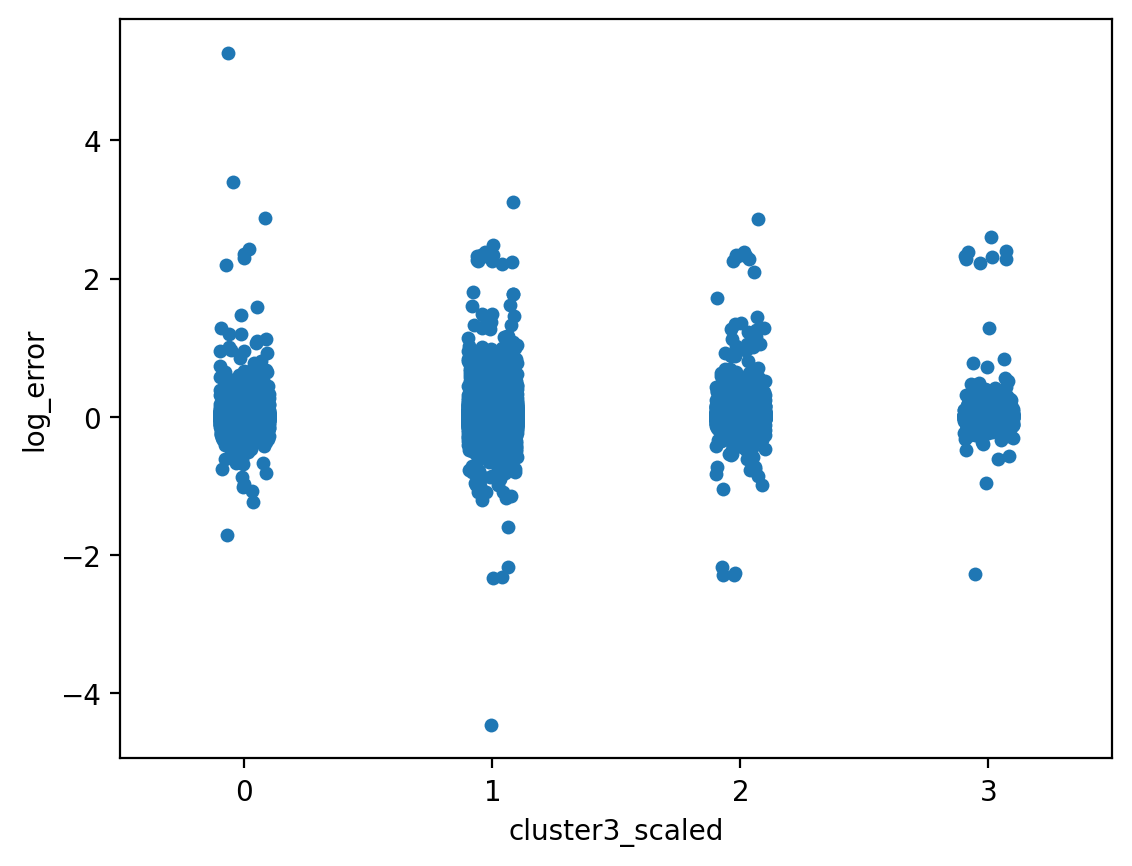

In [22]:
sns.stripplot(data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')

Text(0.5, 1.0, 'Scaled')

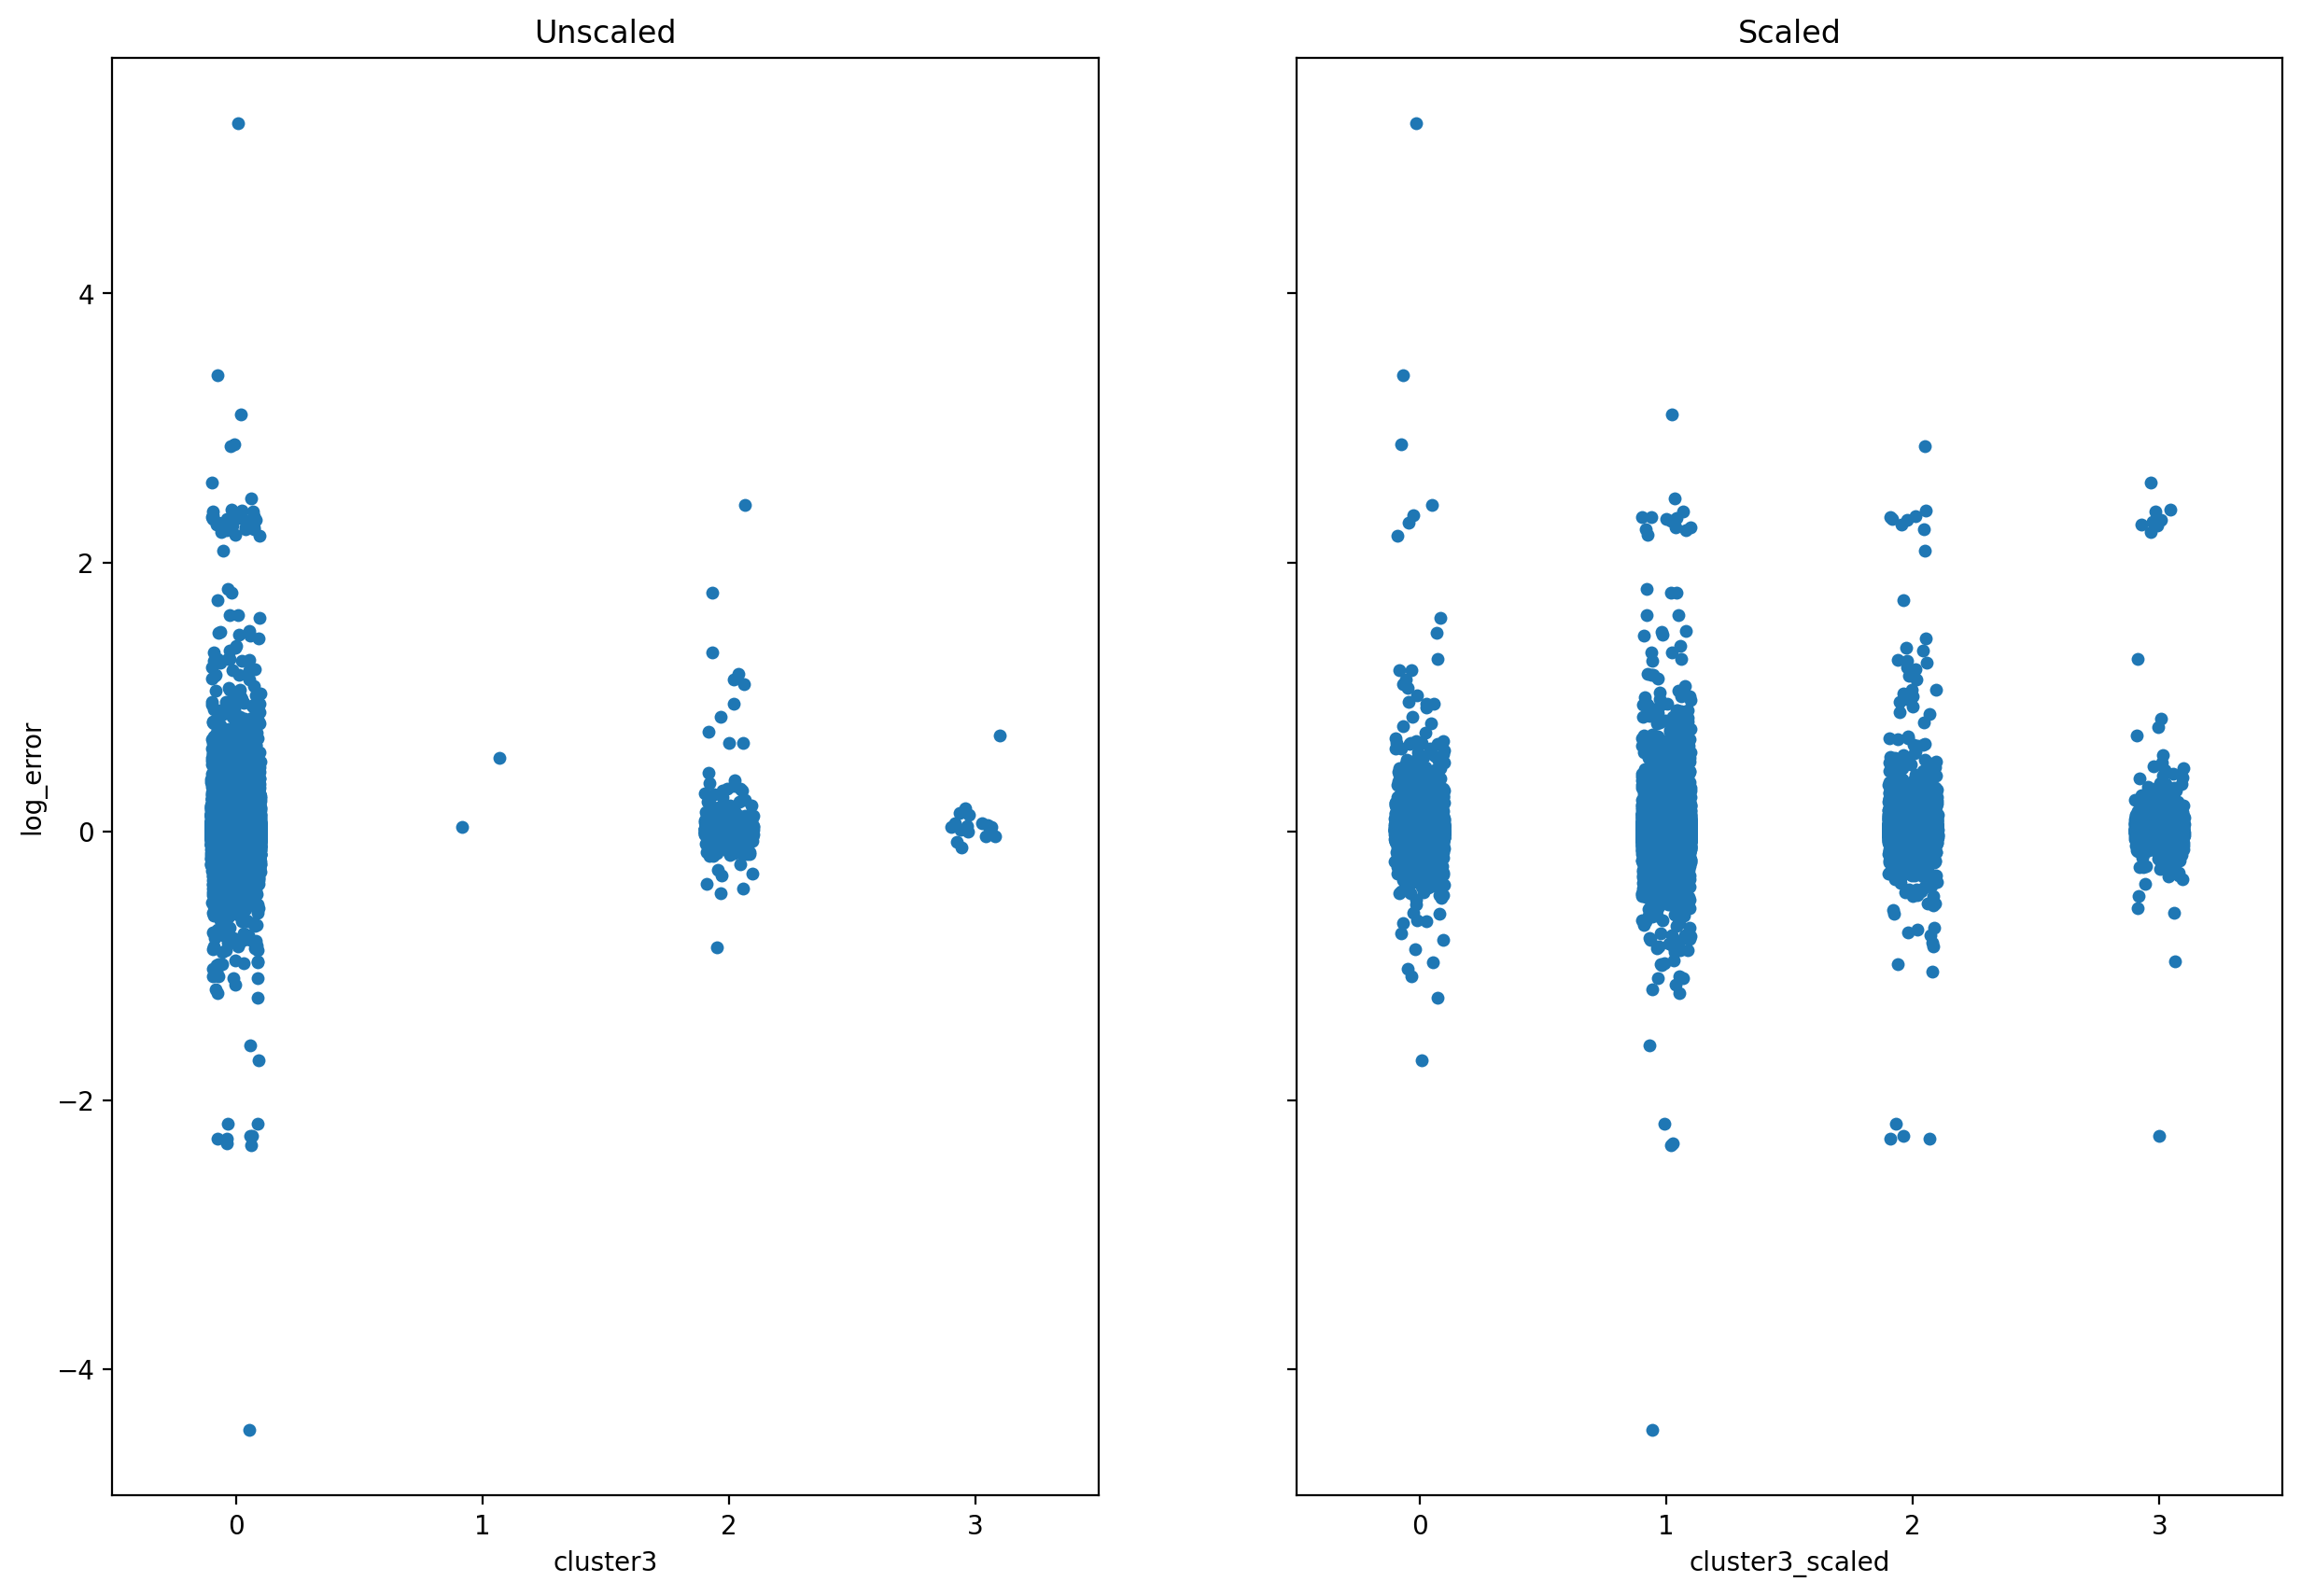

In [23]:
fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
fig.subtitle = ('Unscaled vs. Scaled')

#Unscaled
sns.stripplot(ax=axes[0], data = train, x = 'cluster3', y = 'log_error')
axes[0].set_title('Unscaled')

#Scaled
sns.stripplot(ax = axes[1],data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')
axes[1].set_title('Scaled')

In [24]:
def viz_for_Q3(train_df):
    
    #unscaled data
    X3 = train[['garage_car_count', 'pool_count', 'lot_sqft']]
    kmeans = KMeans(n_clusters = 4).fit(X3)
    train['cluster3'] = kmeans.predict(X3)
    
    #scaled data
    train_scaled3 = w.scale(train, ['garage_car_count', 'pool_count', 'lot_sqft'])
    X3_scaled = train_scaled3[['scaled_garage_car_count', 'scaled_pool_count', 'scaled_lot_sqft']]
    kmeans = KMeans(n_clusters = 4).fit(X3_scaled)
    train_scaled3['cluster3_scaled'] = kmeans.predict(X3_scaled)
    train_scaled3['log_error'] = train['log_error']
    
    #viz 
    fig, axes= plt.subplots(1,2, figsize =(15, 10), sharey = True)
    fig.subtitle = ('Unscaled vs. Scaled')

    #Unscaled
    sns.stripplot(ax=axes[0], data = train, x = 'cluster3', y = 'log_error')
    axes[0].set_title('Unscaled')

    #Scaled
    sns.stripplot(ax = axes[1],data = train_scaled3, x = 'cluster3_scaled', y = 'log_error')
    axes[1].set_title('Scaled')
    
    plt.show()

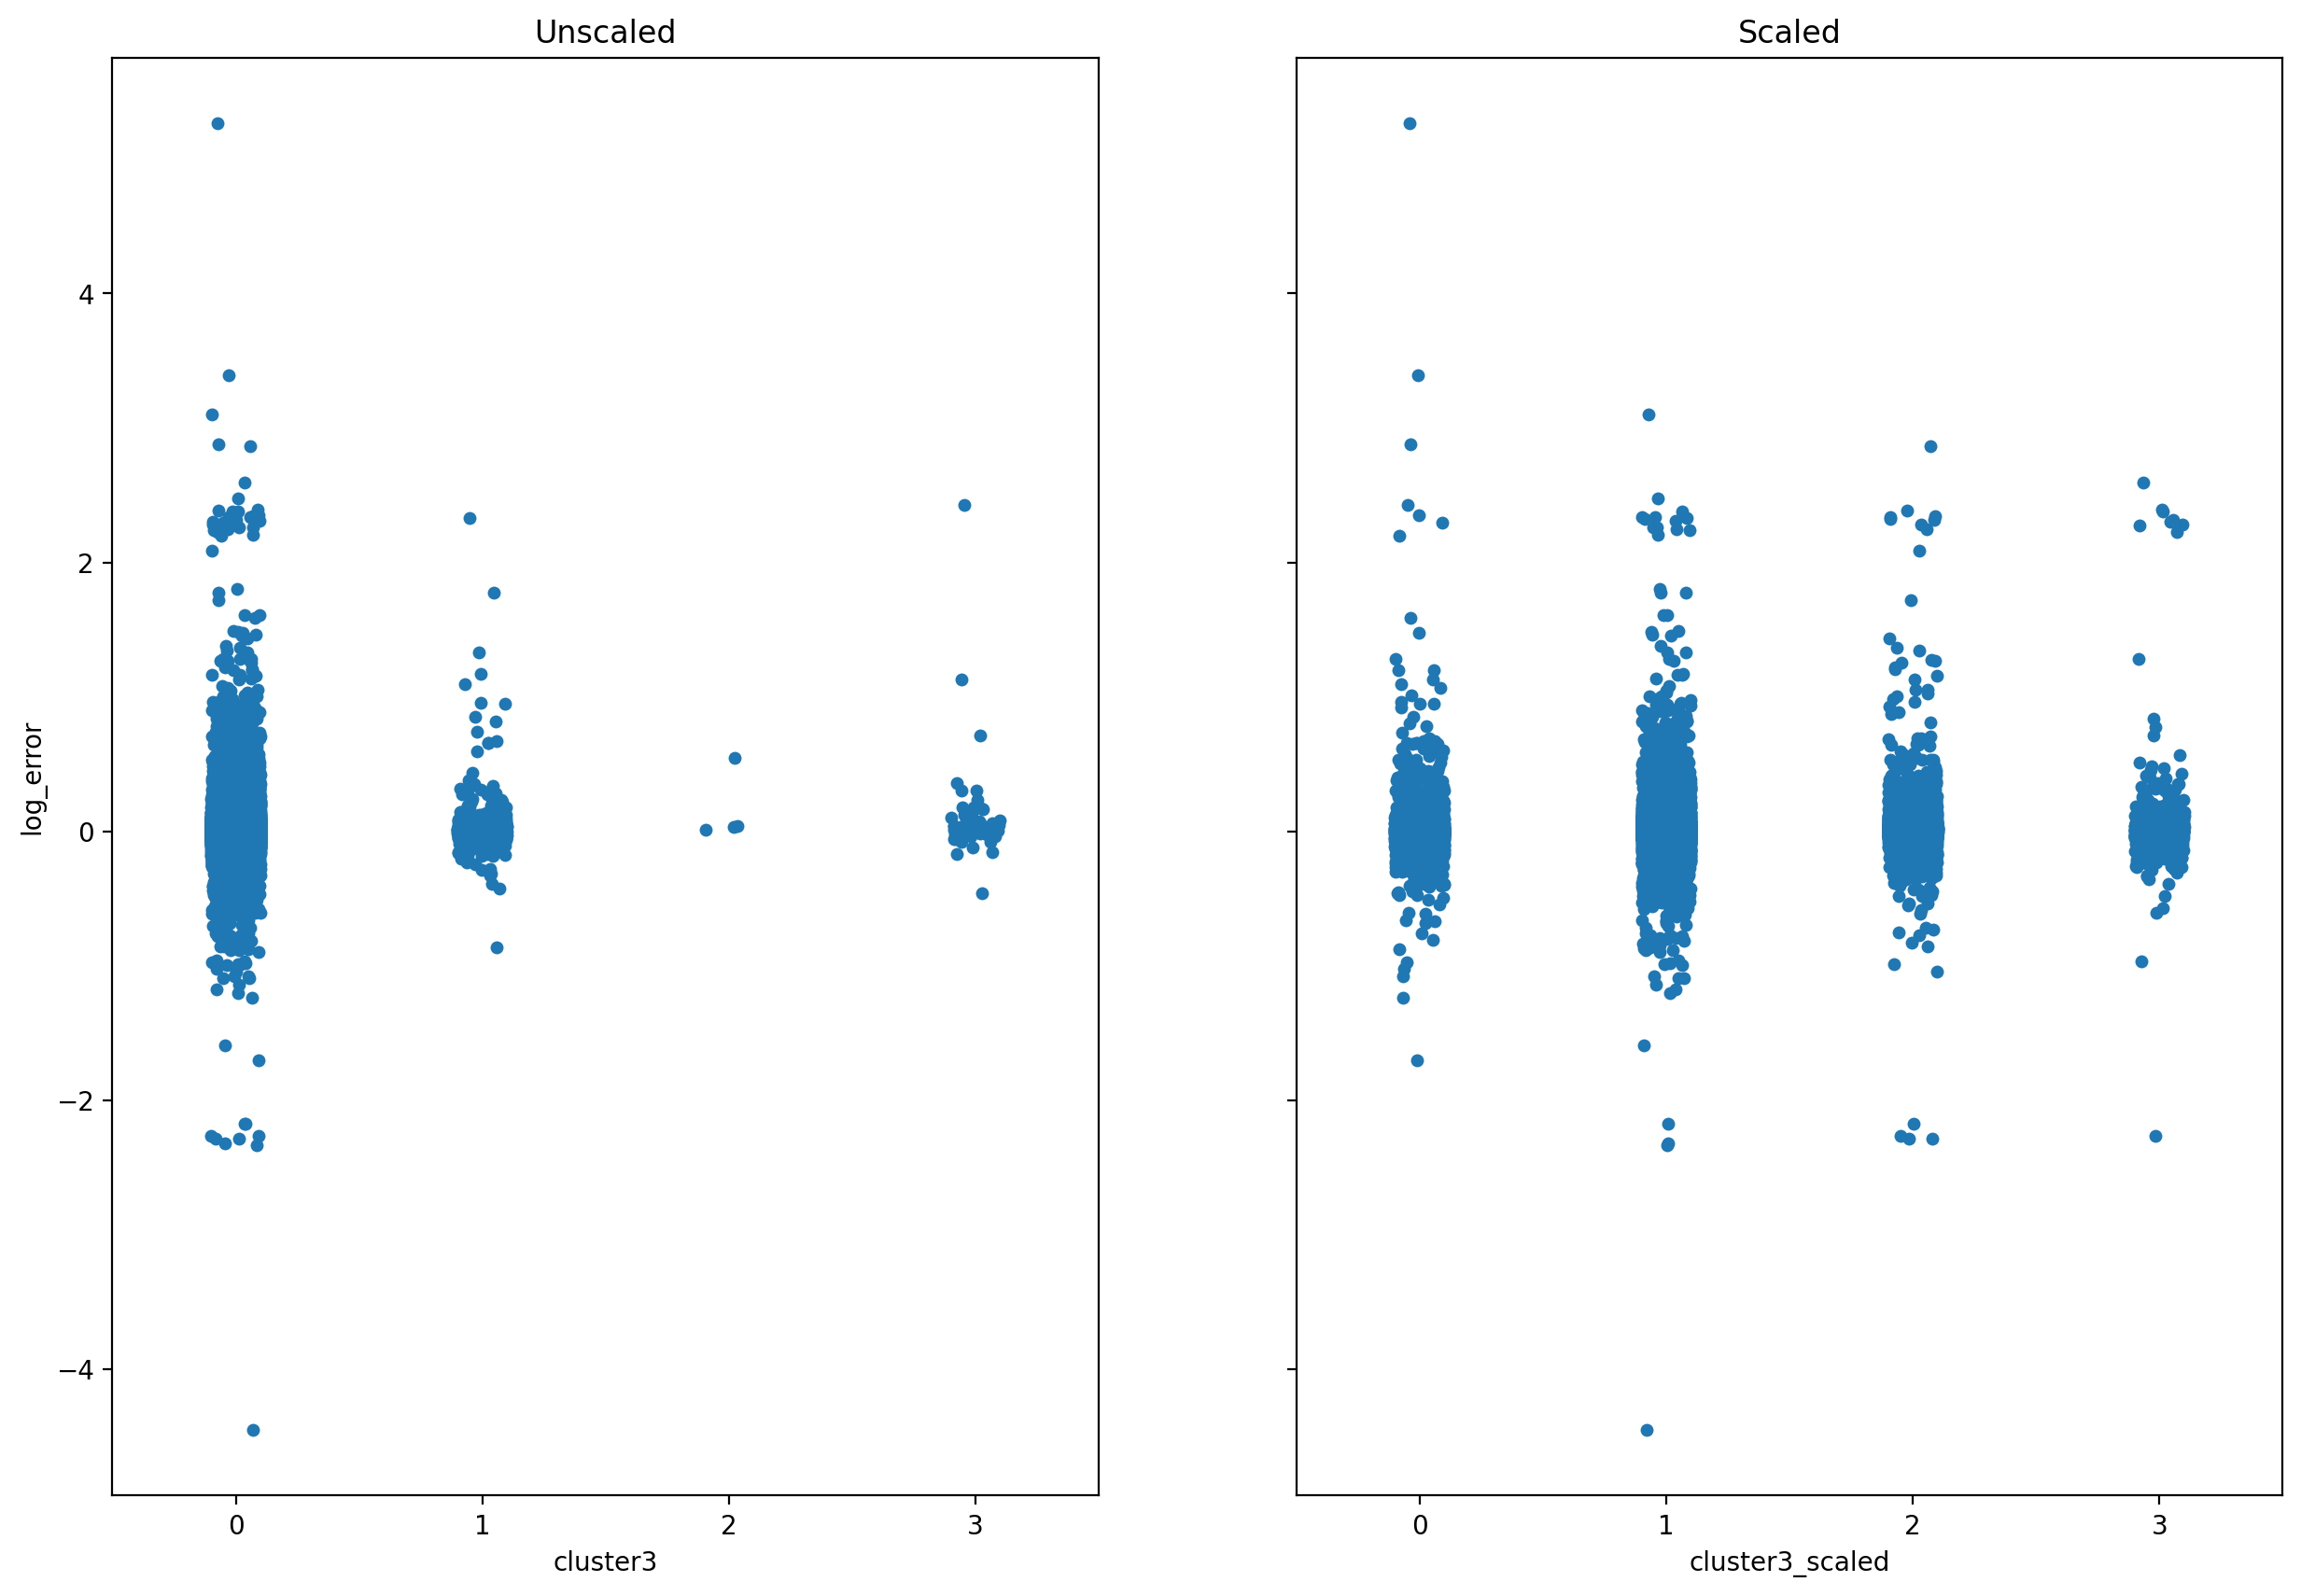

In [25]:
viz_for_Q3(df)

### creating and comparing clusters of features

In [33]:
all_features = train.select_dtypes('number')[['bath_count','bed_count',
'calc_sqft','latitude','longitude','tax_value','fireplace_count']]
cluster_test =train.copy()

In [28]:
train.columns

Index(['Unnamed: 0', 'parcel_id', 'bath_count', 'bed_count',
       'calc_bath_and_bed', 'calc_sqft', 'finished_sqft12', 'fips',
       'fireplace_count', 'full_bath_count', 'garage_car_count', 'latitude',
       'longitude', 'lot_sqft', 'pool_count', 'property_county_use_code',
       'property_zoning_desc', 'raw_census_tract_block', 'region_id_city',
       'region_id_county', 'region_id_zip', 'room_count', 'unit_count',
       'year_built', 'structure_tax_value', 'tax_value', 'assessment_year',
       'land_value', 'tax_amount', 'census_tract_and_block', 'log_error',
       'transaction_date', 'heating_system_desc', 'property_land_use_desc',
       'log_error_outliers', 'outliers', 'bound_group', 'true_error',
       'cluster3'],
      dtype='object')

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


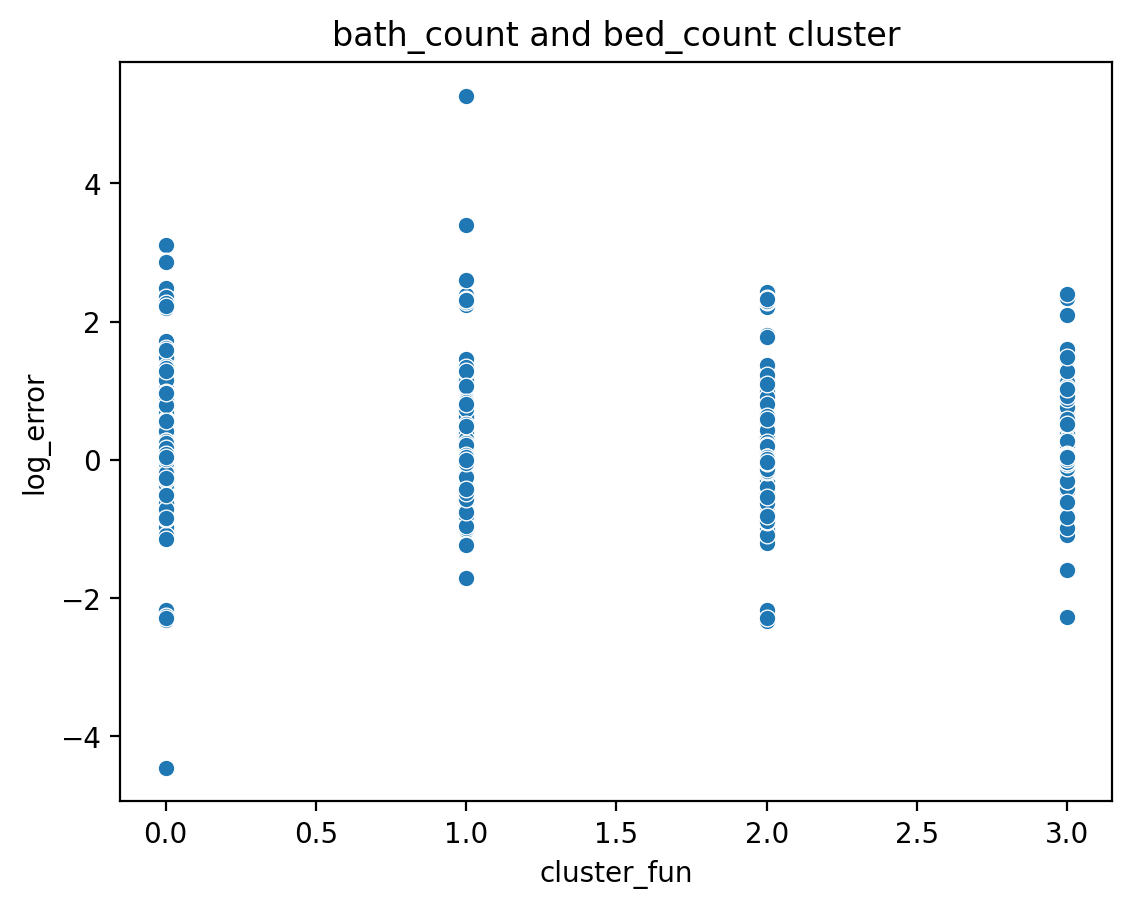

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


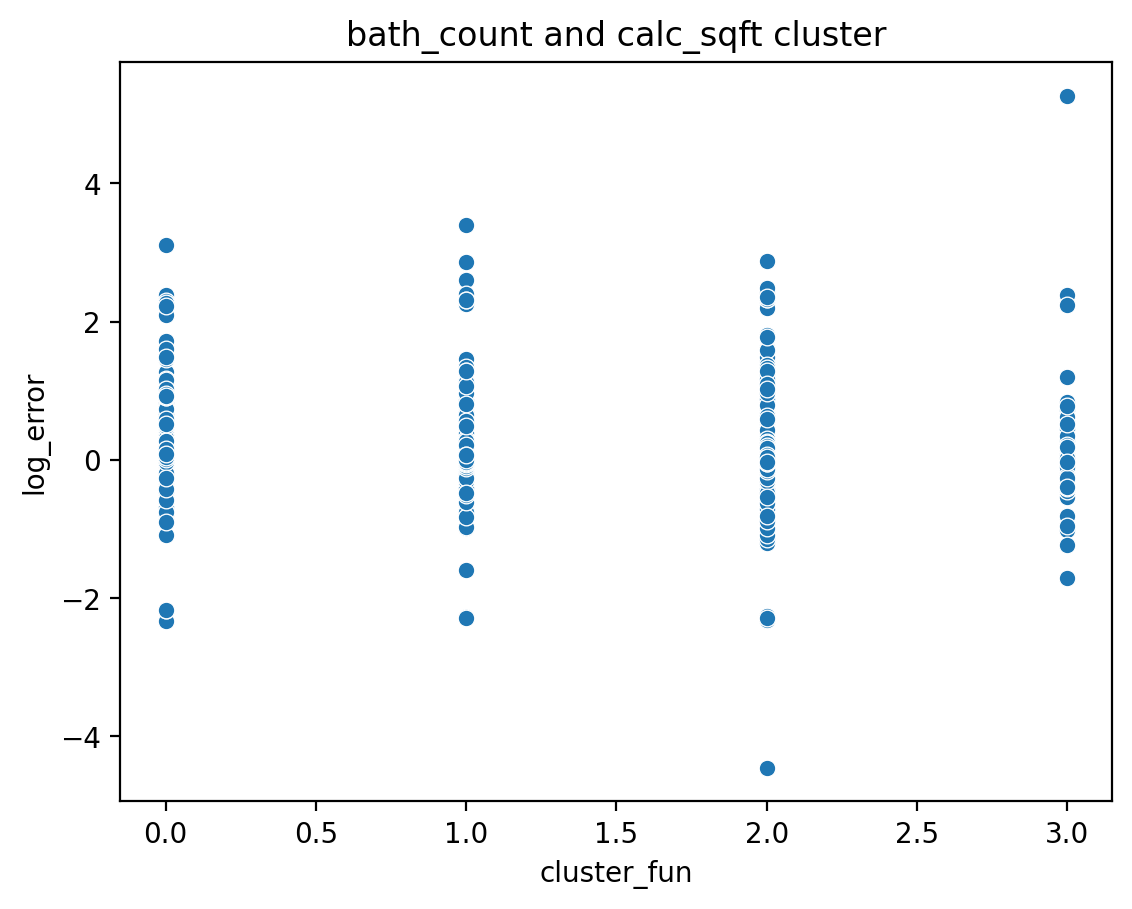

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


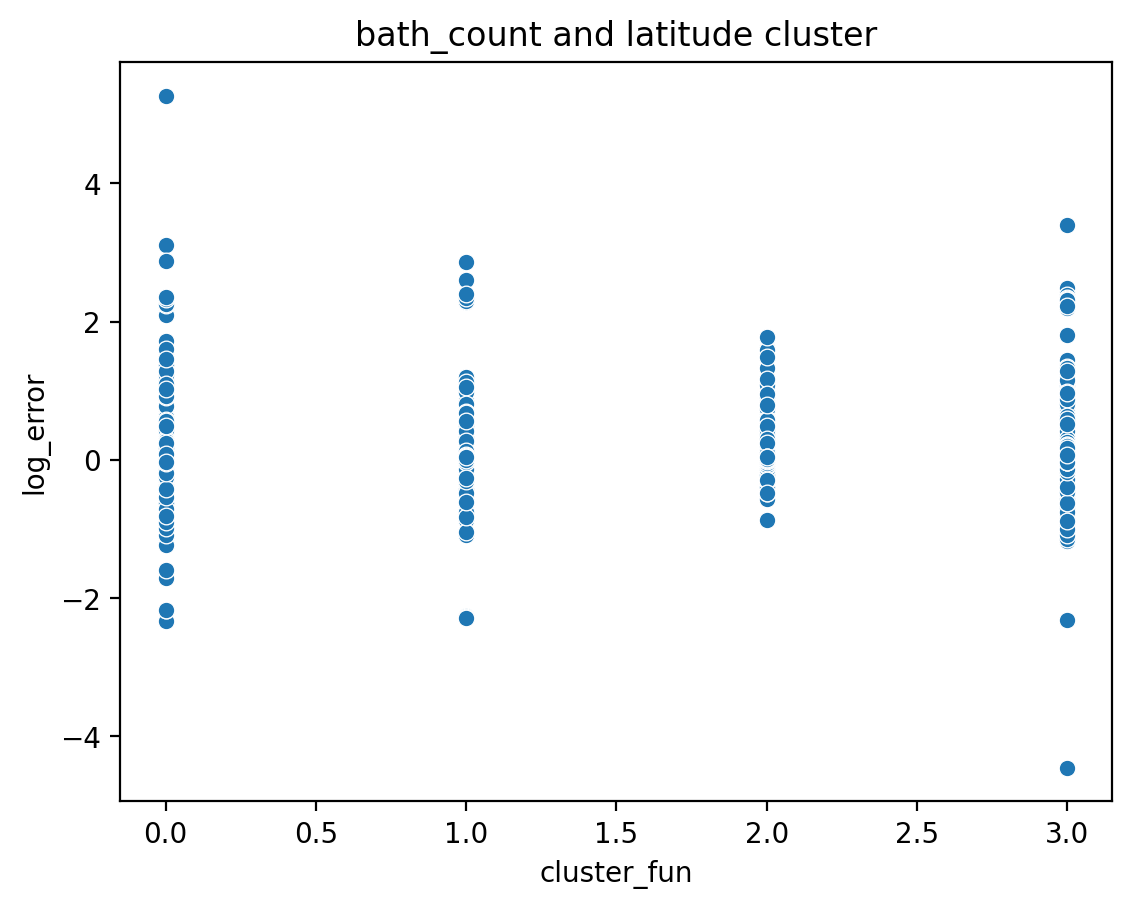

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


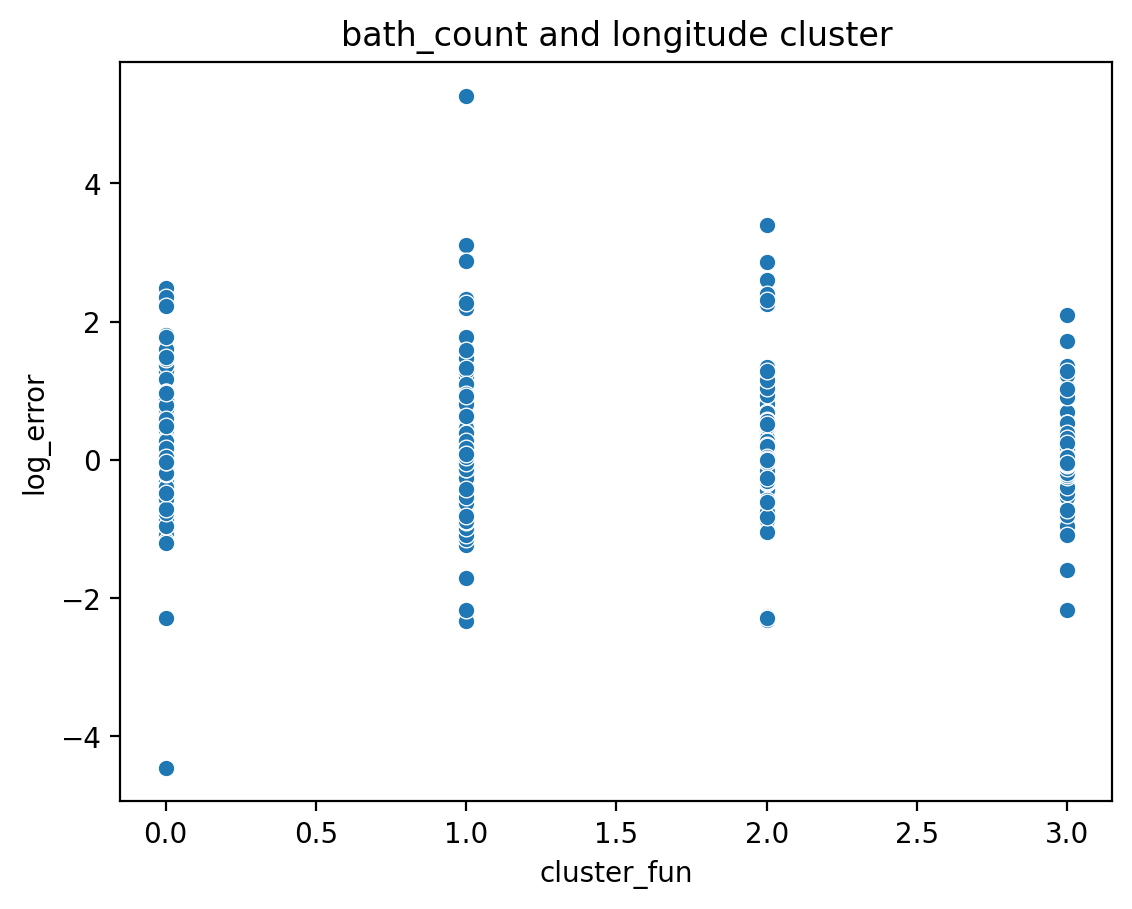

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


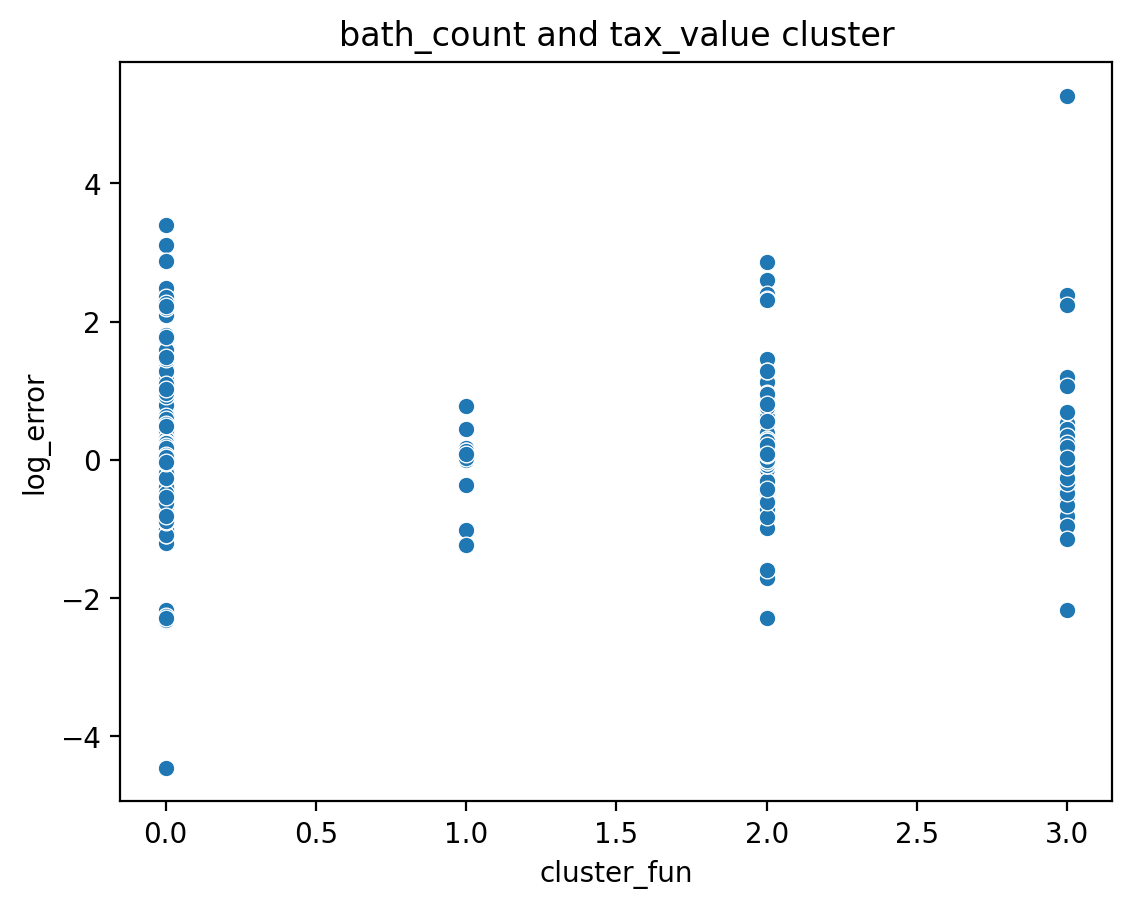

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


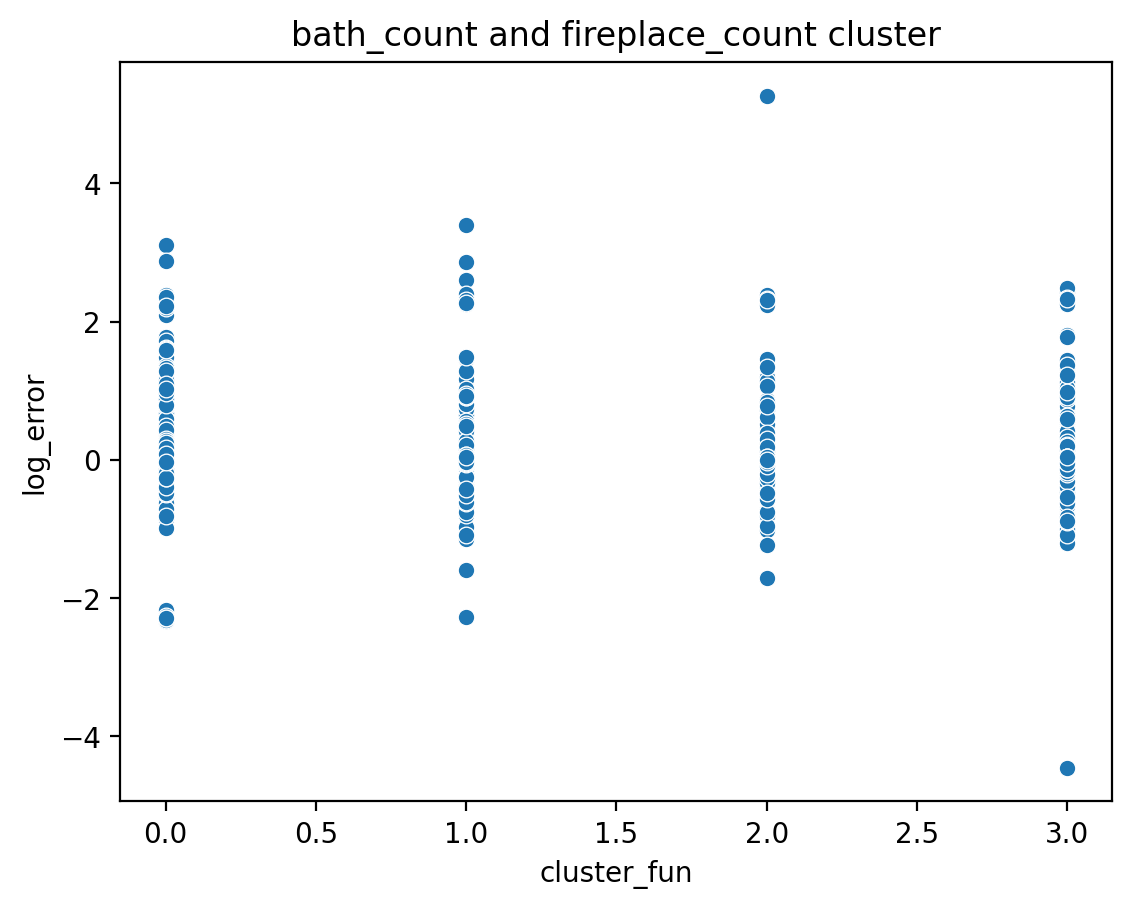

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


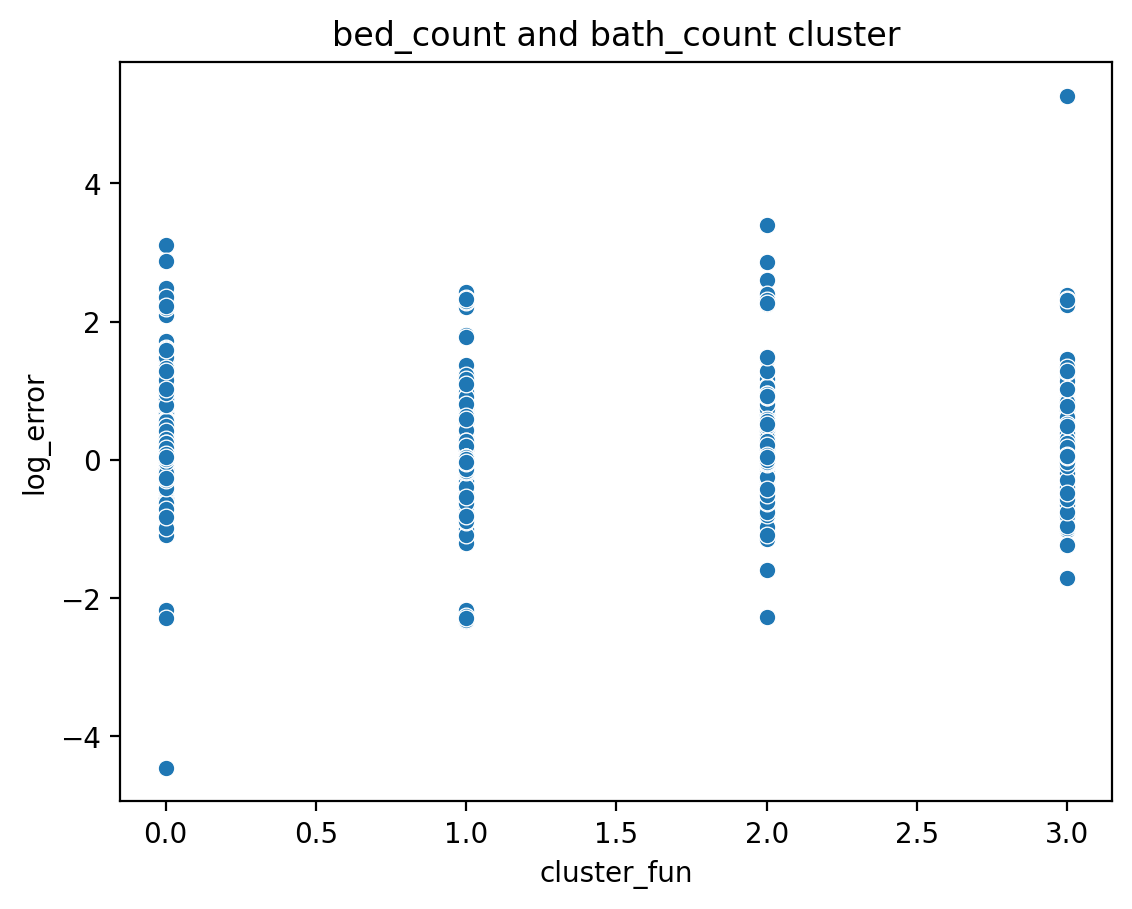

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


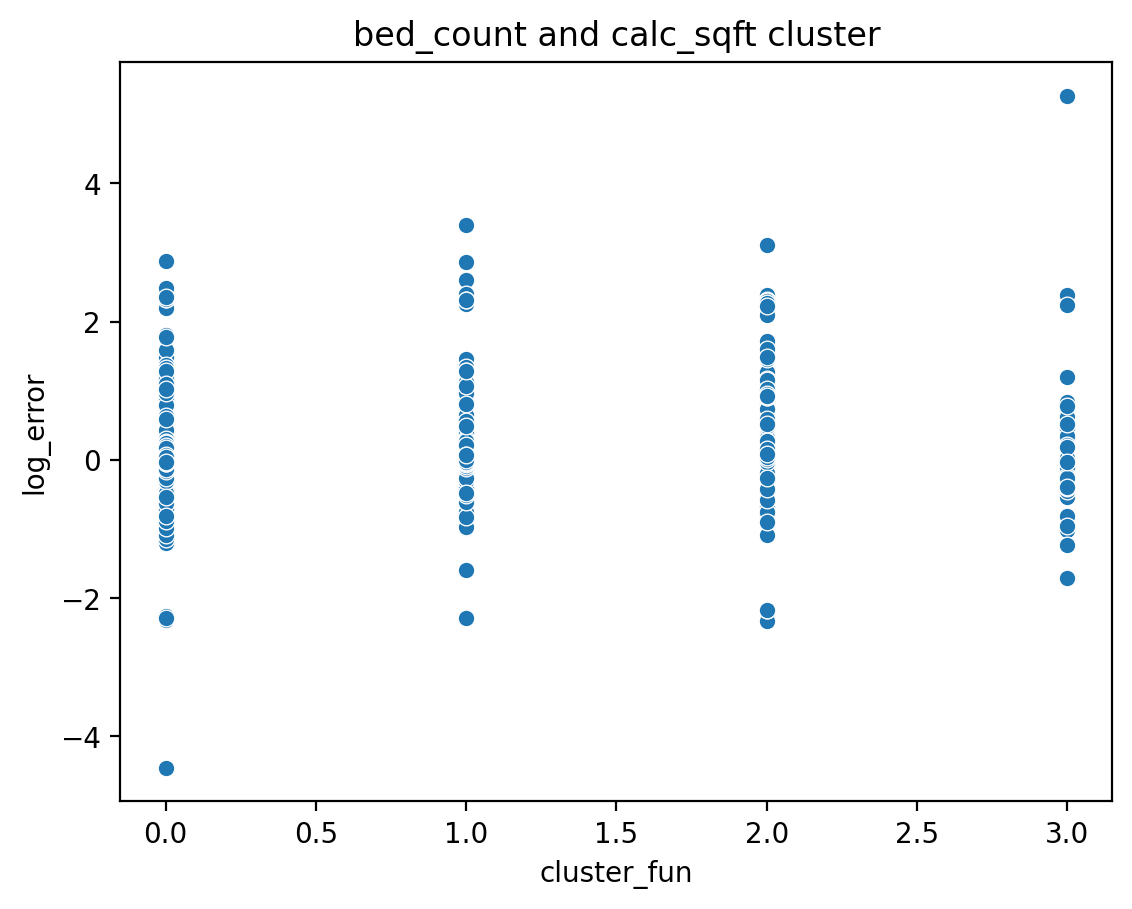

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


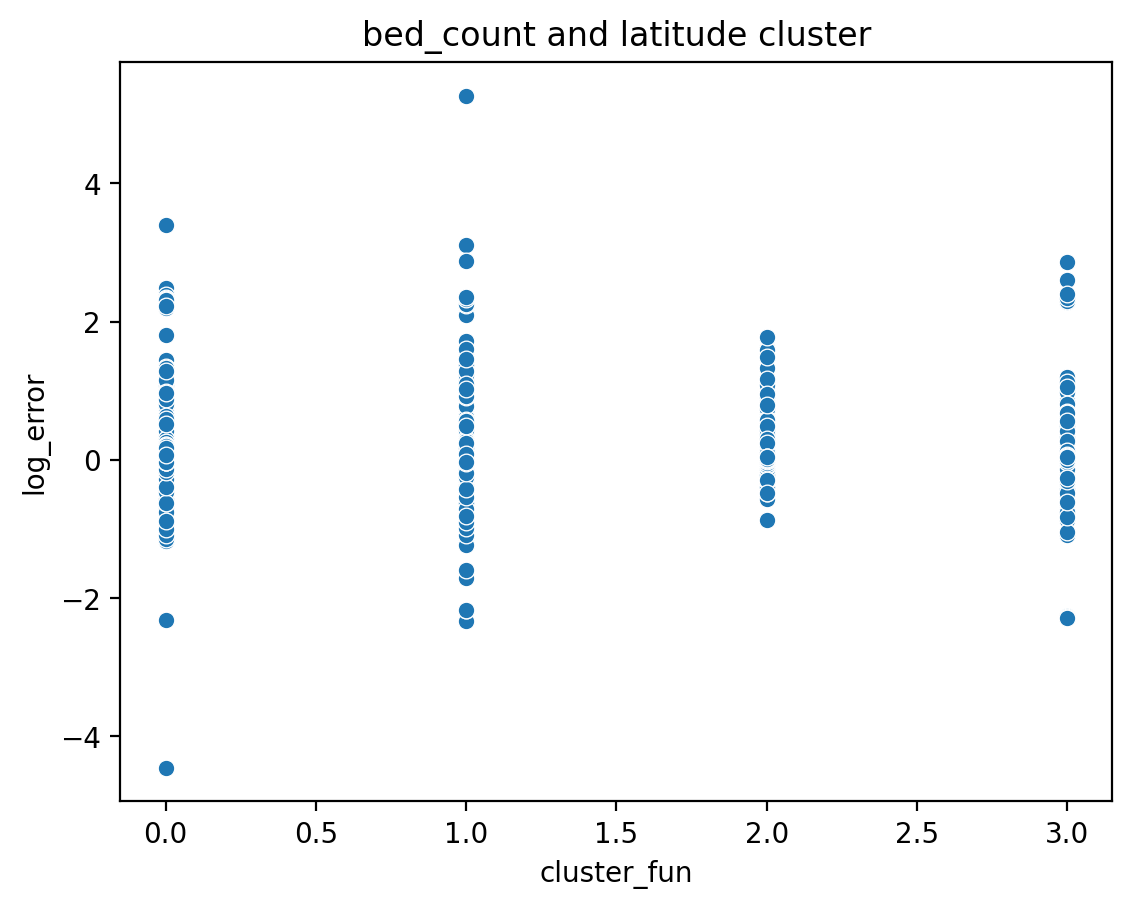

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


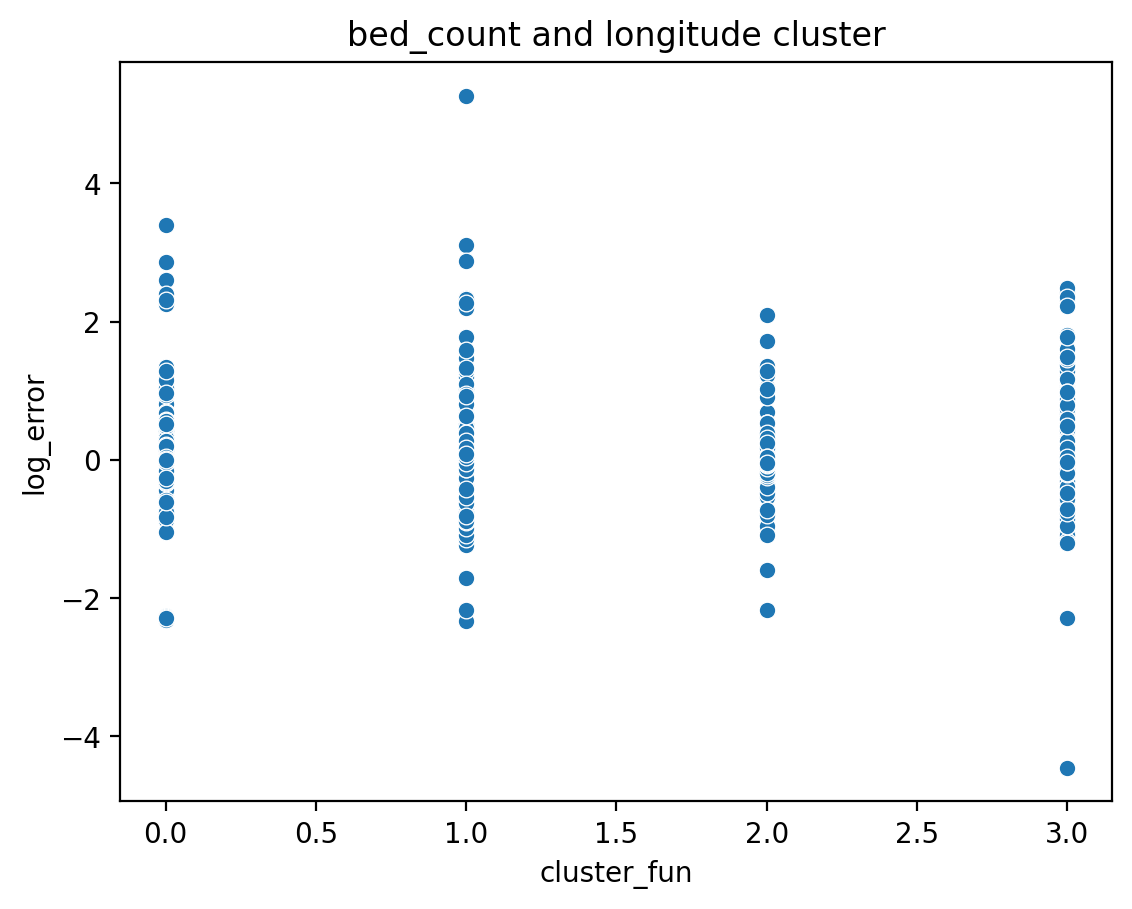

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


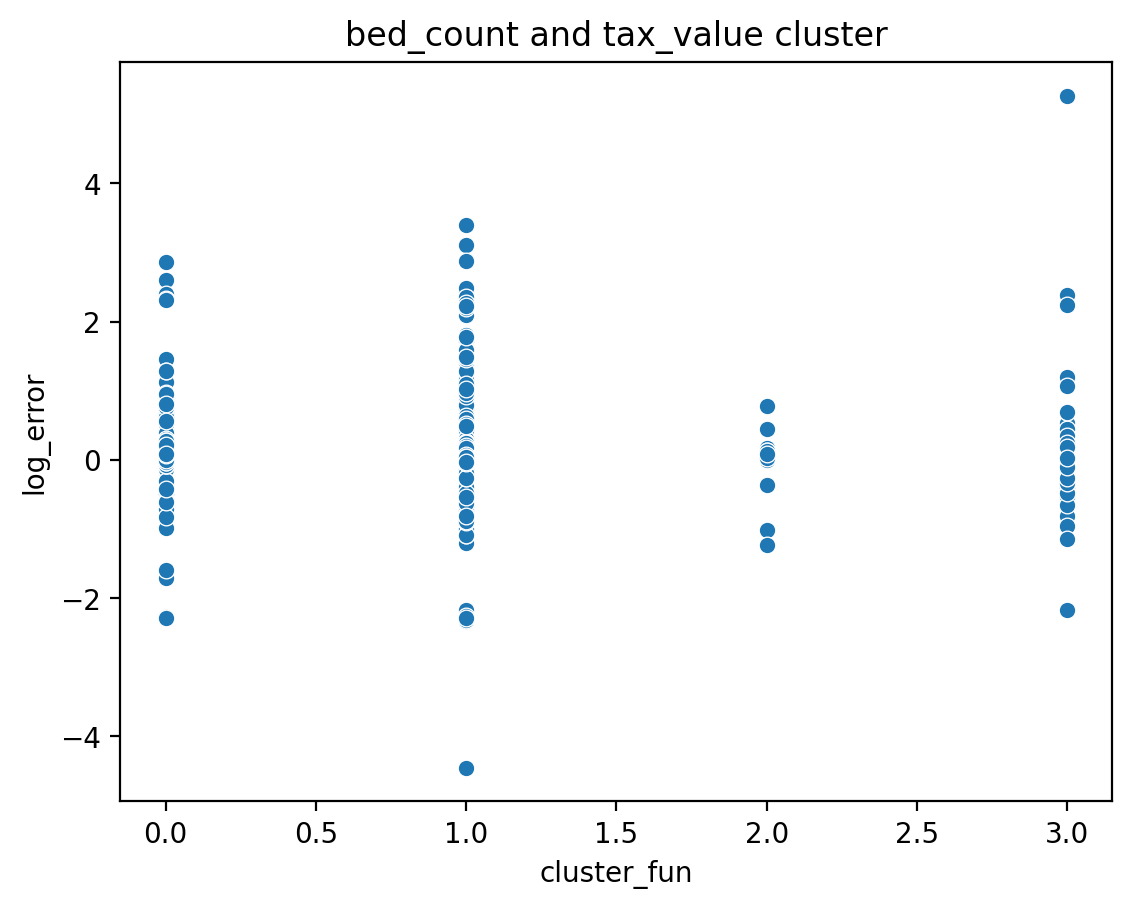

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


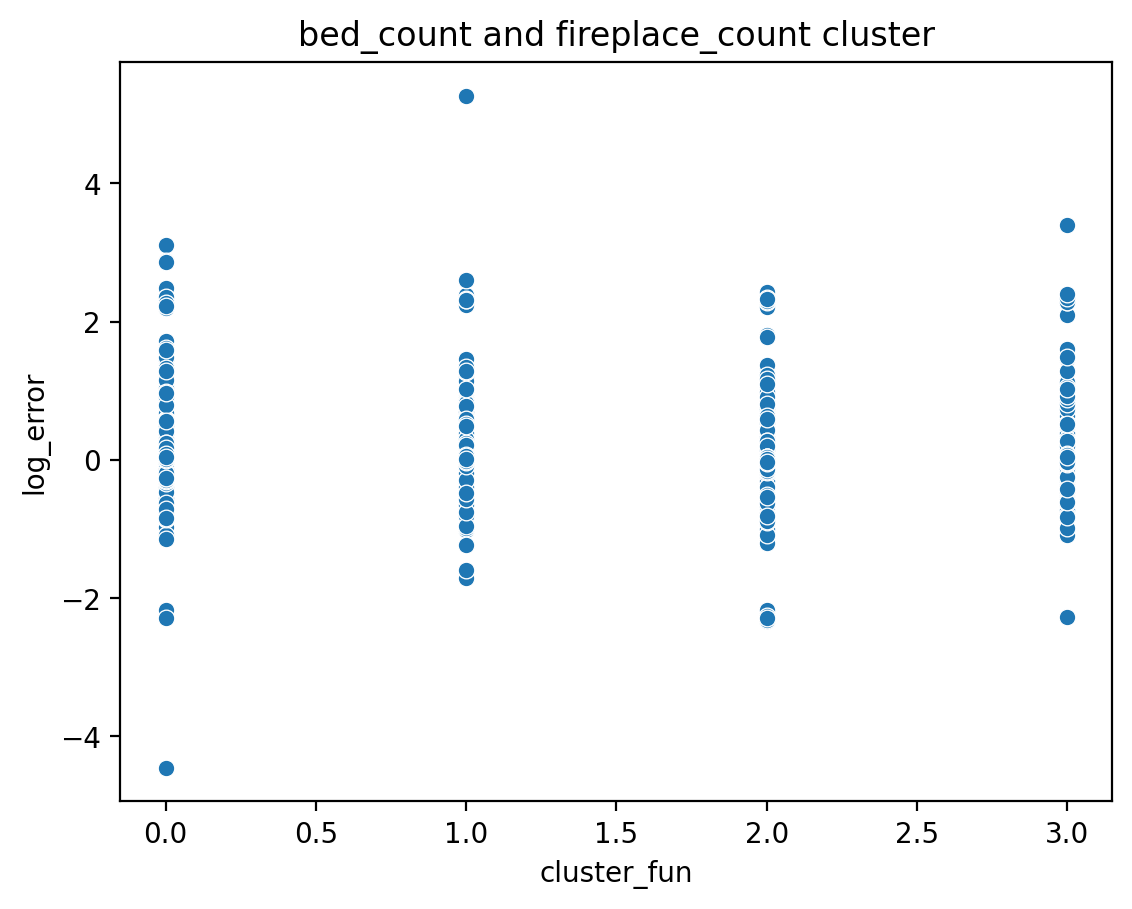

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


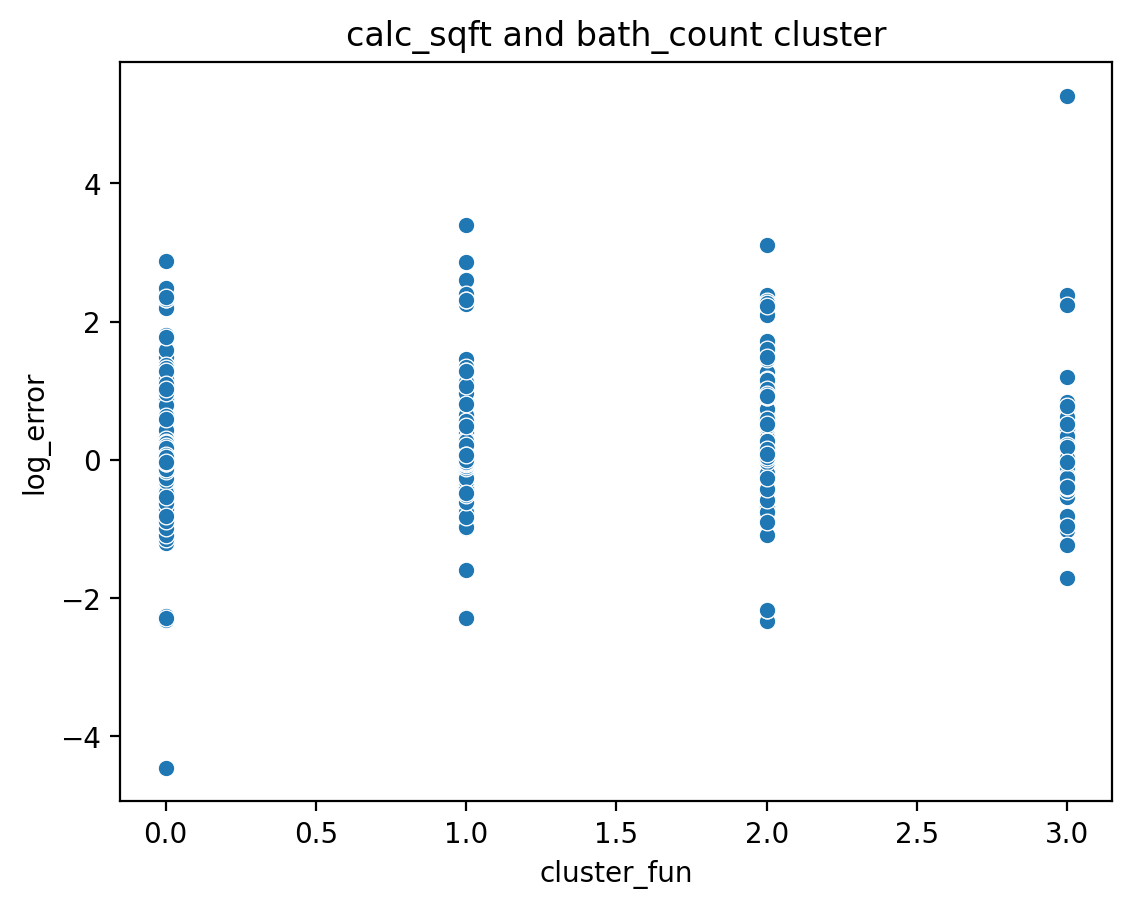

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


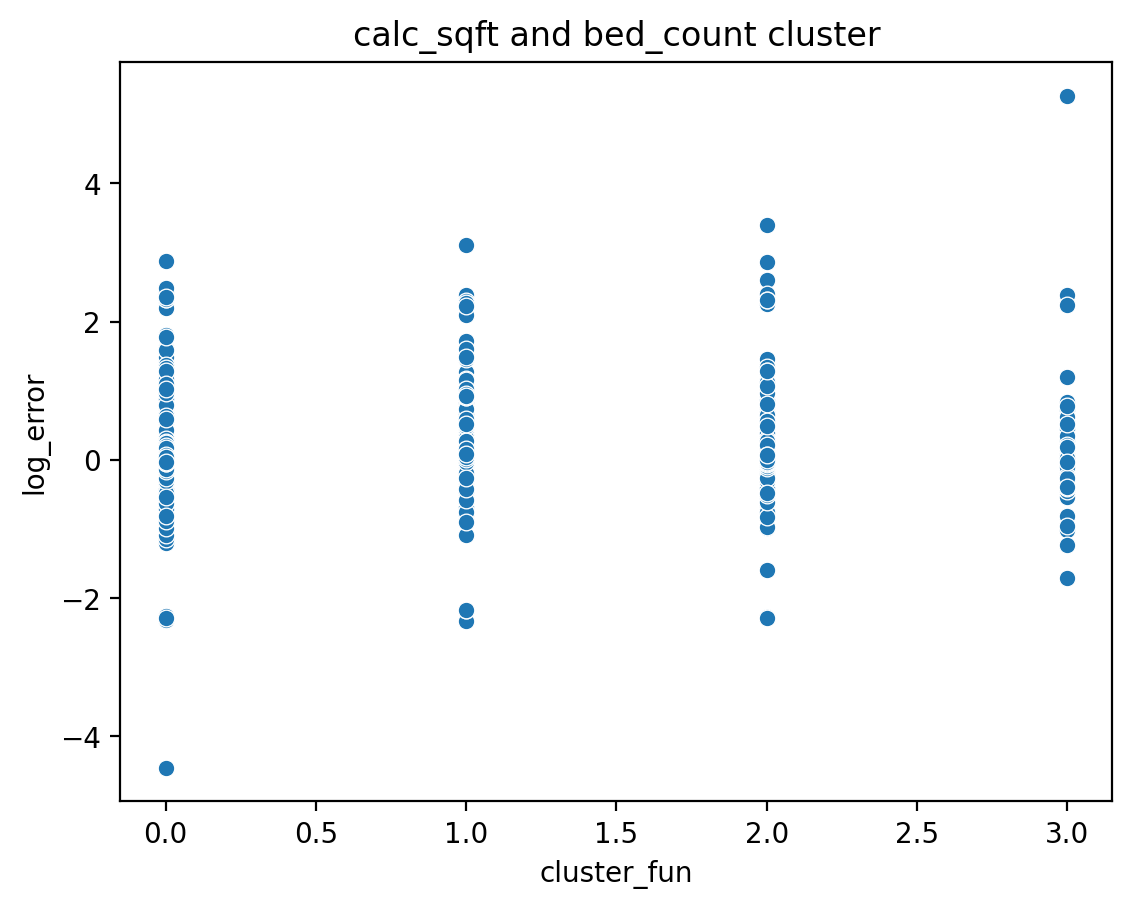

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


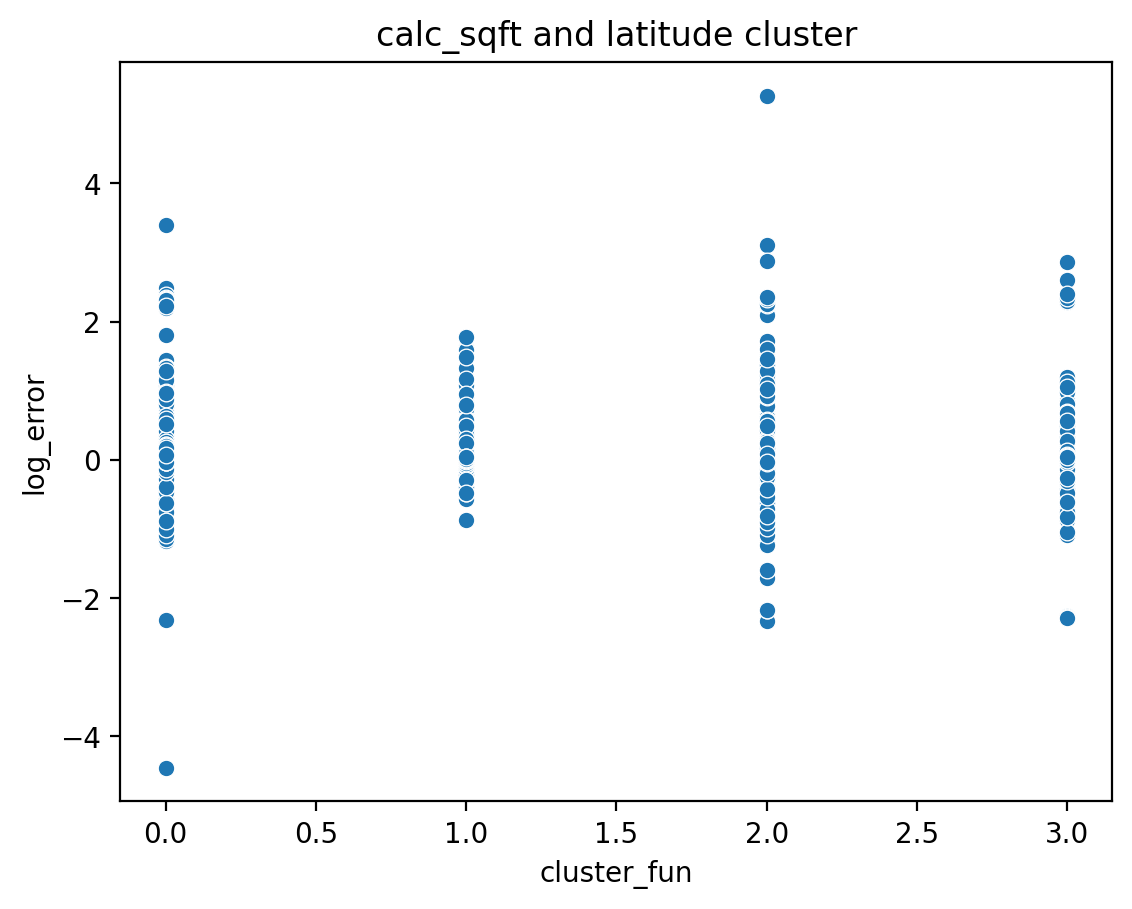

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


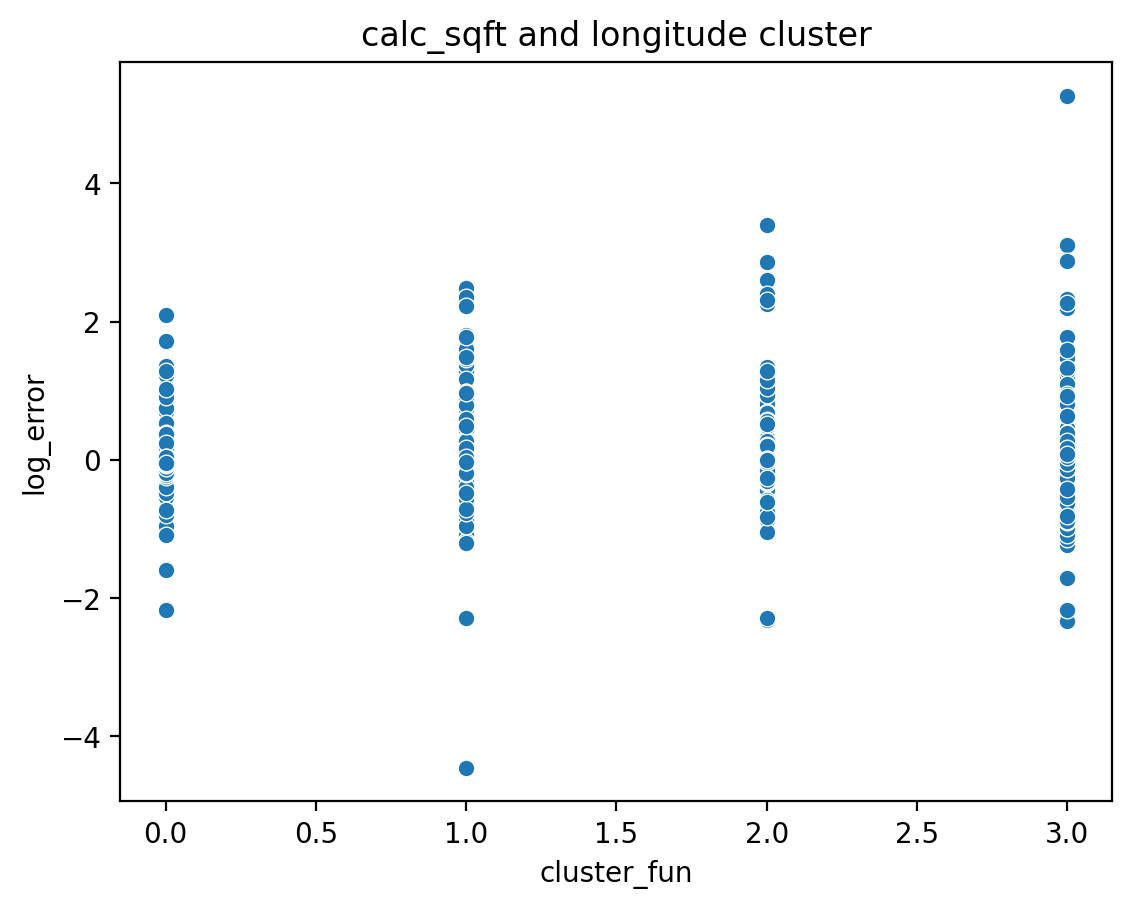

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


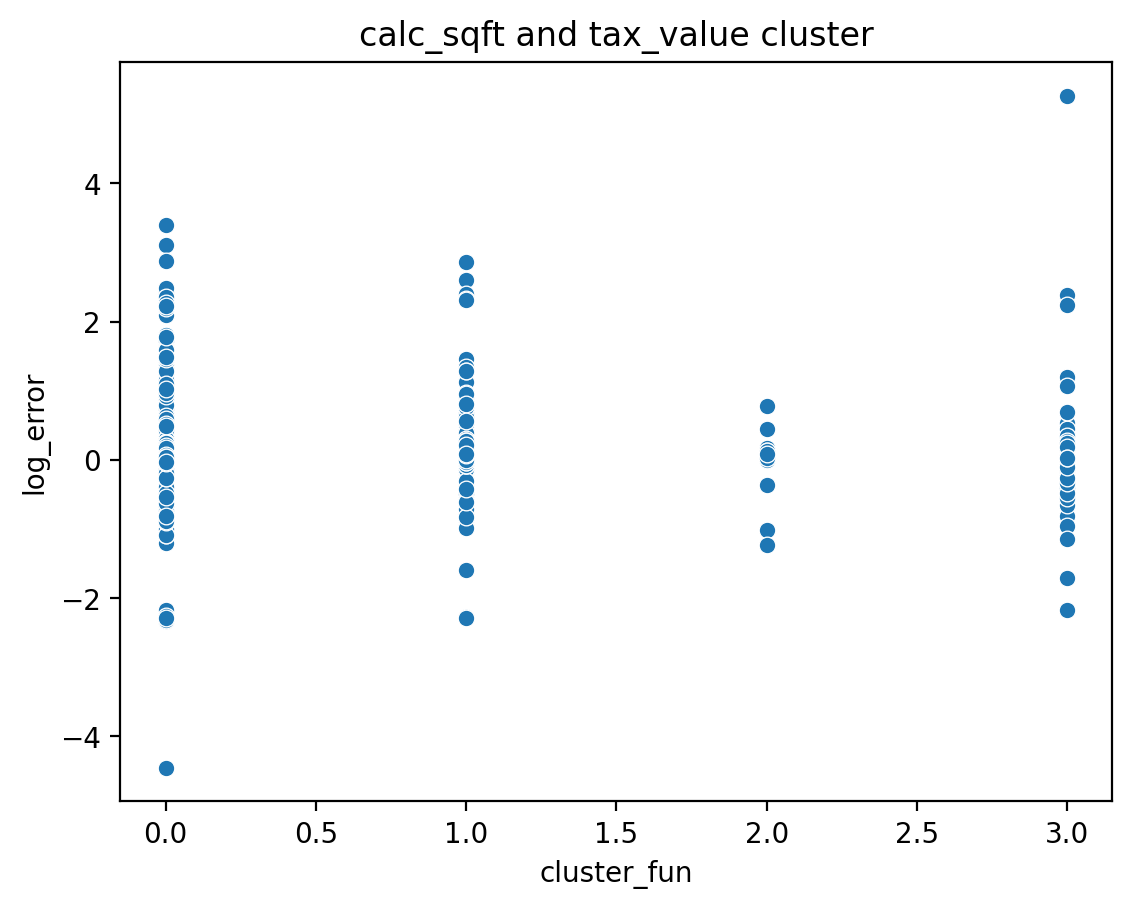

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


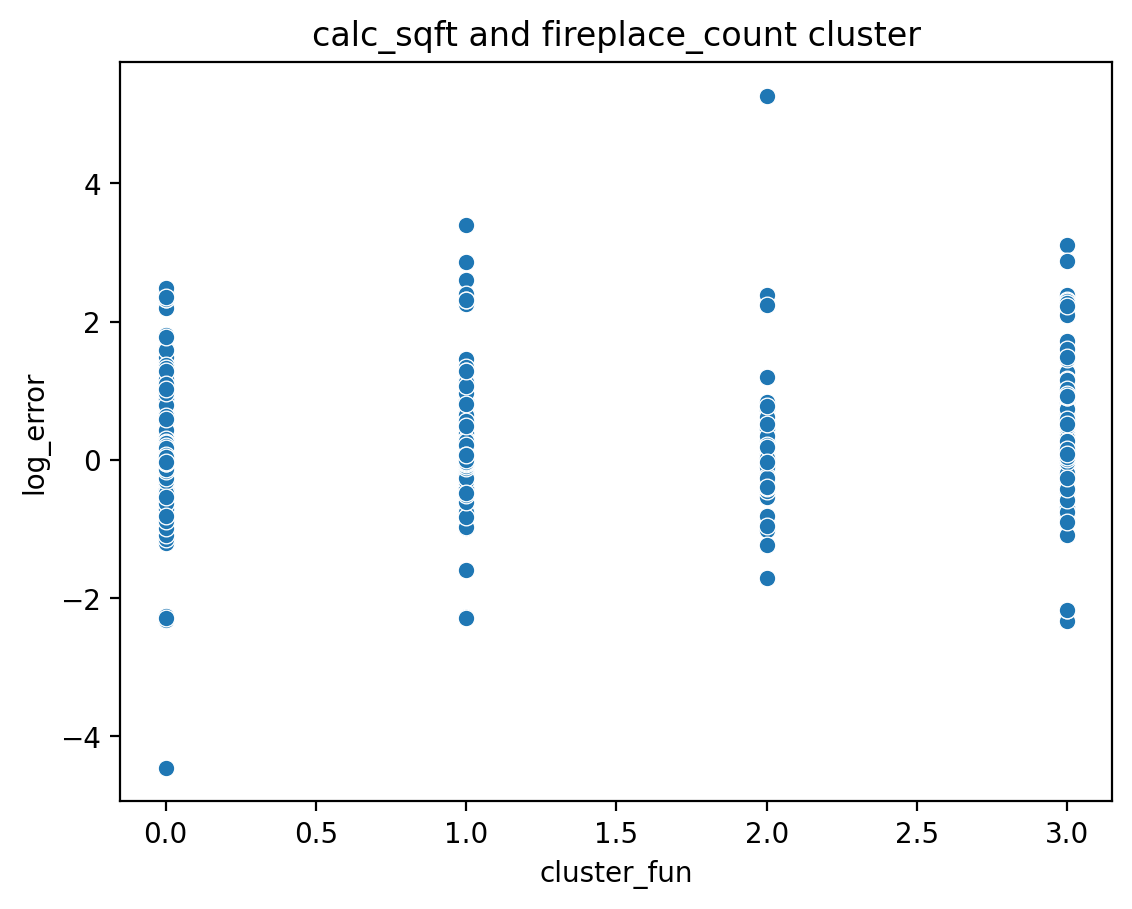

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


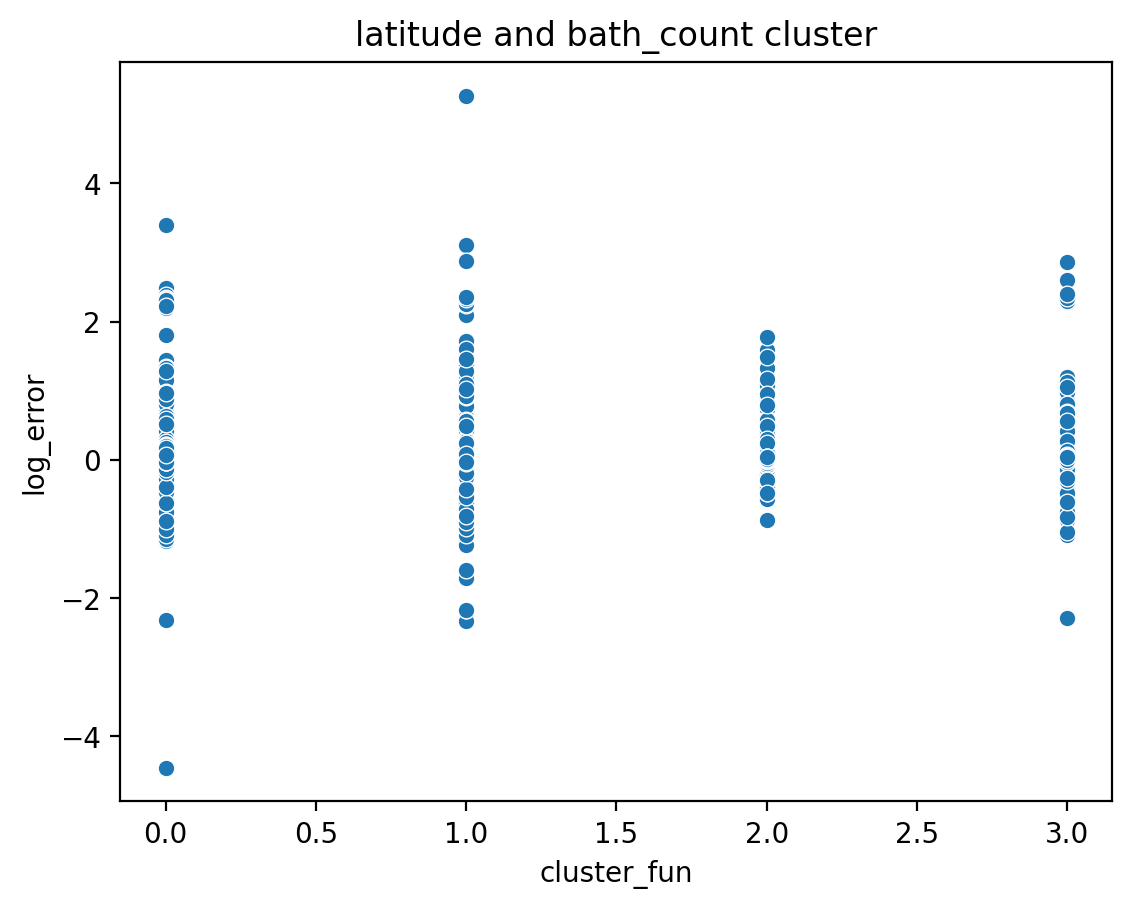

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


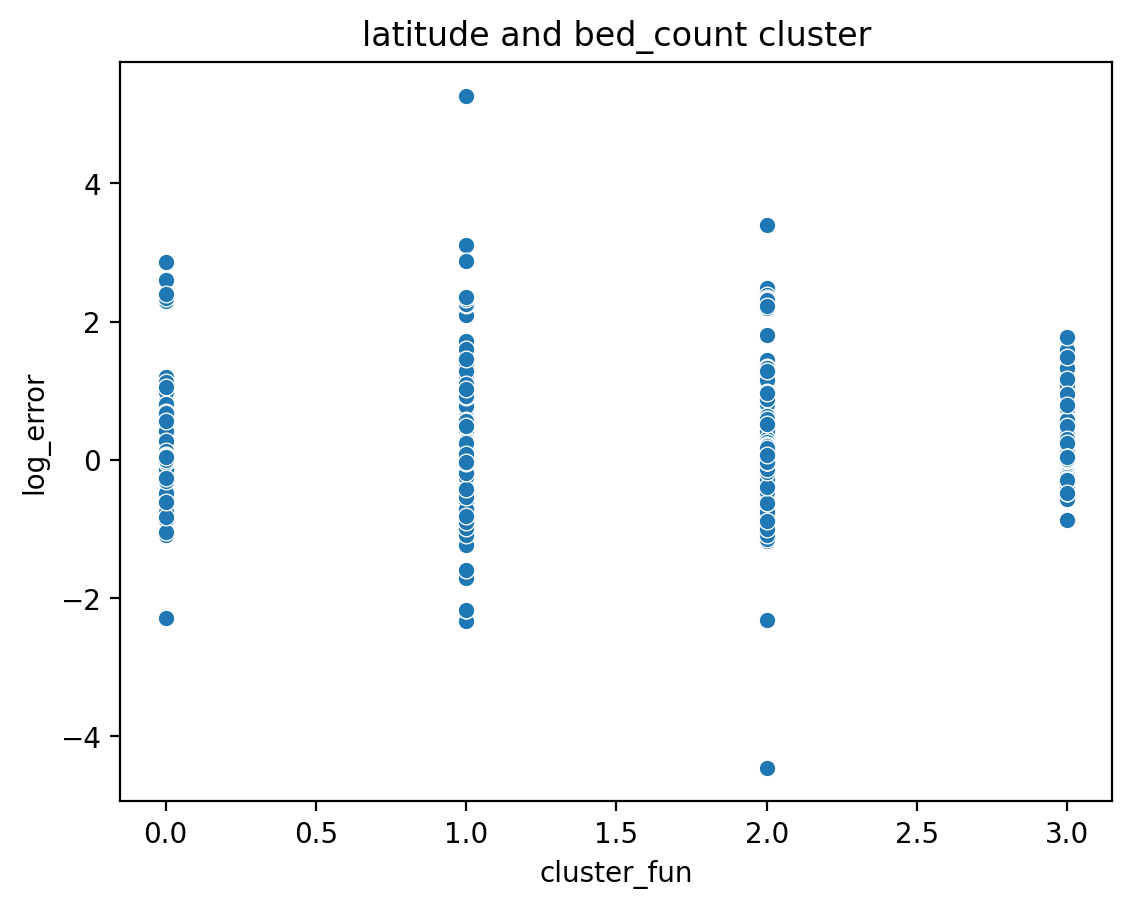

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


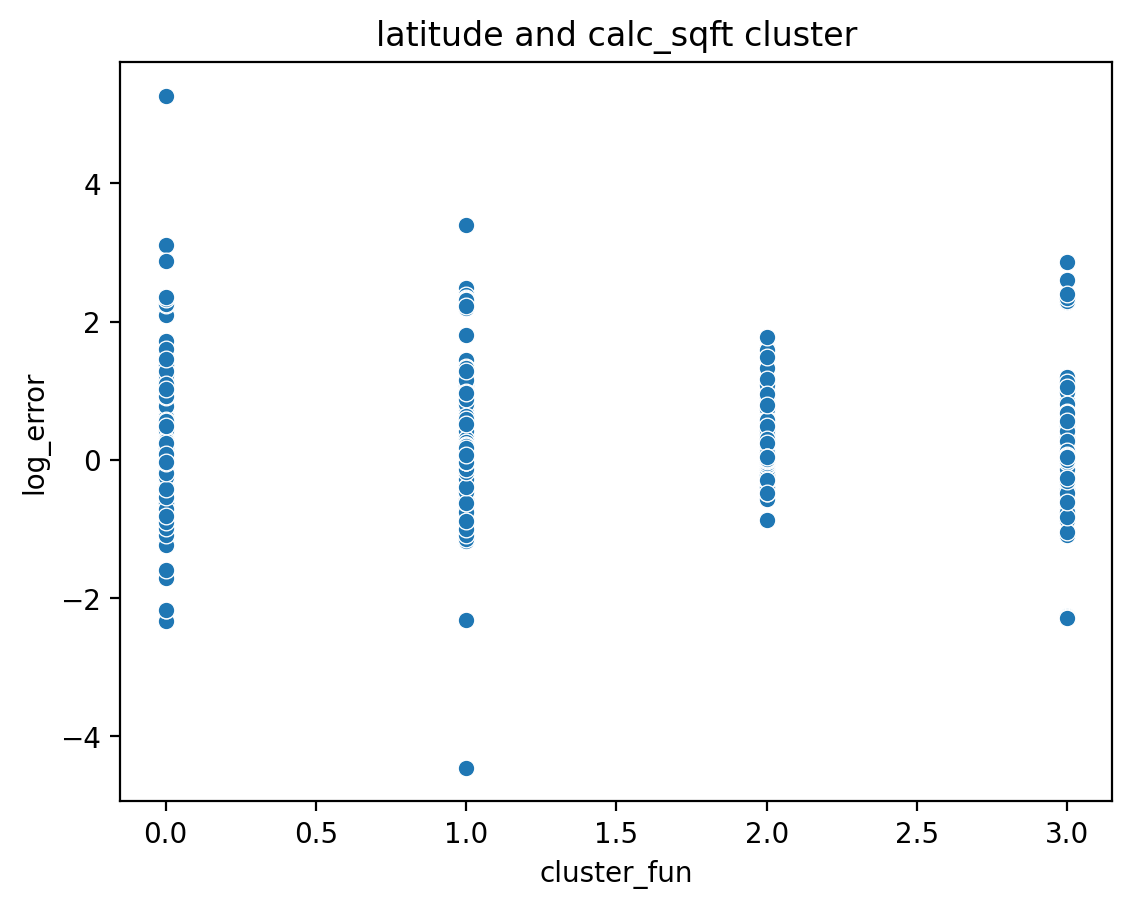

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


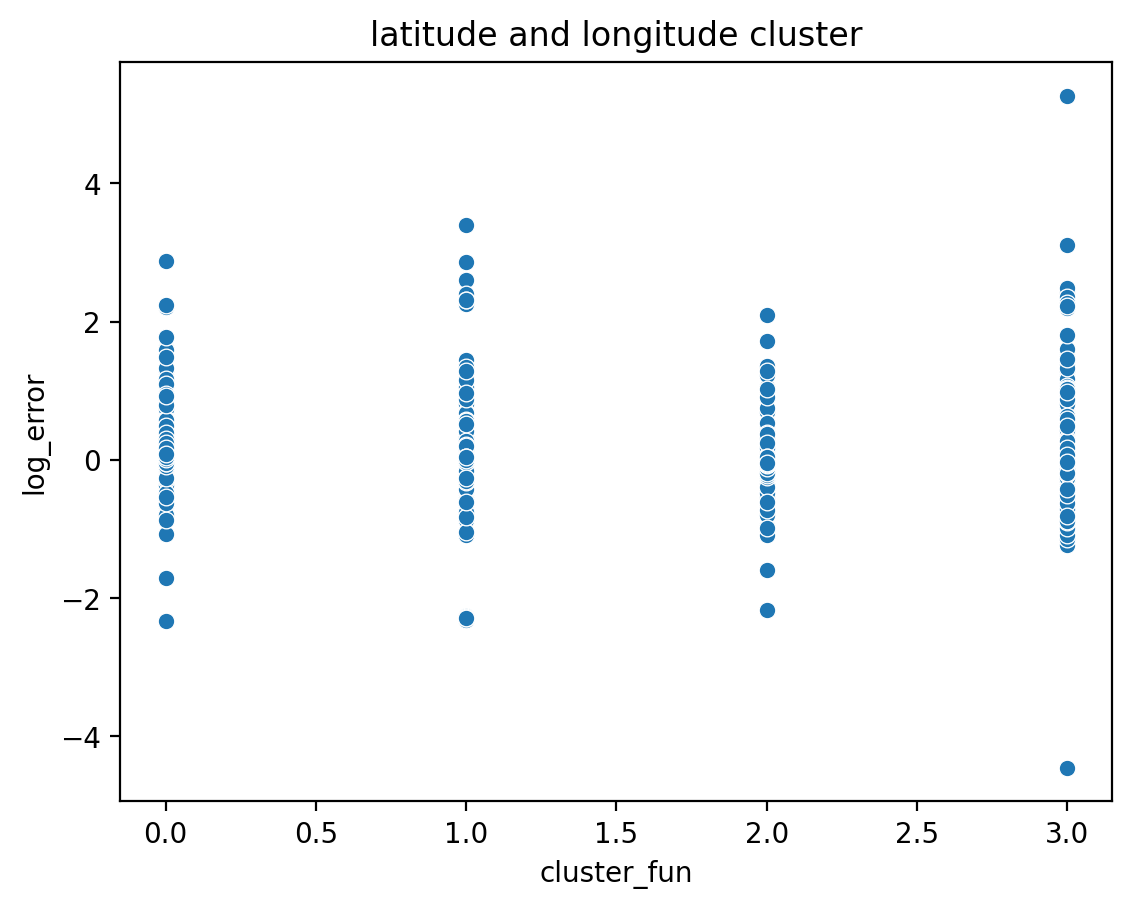

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


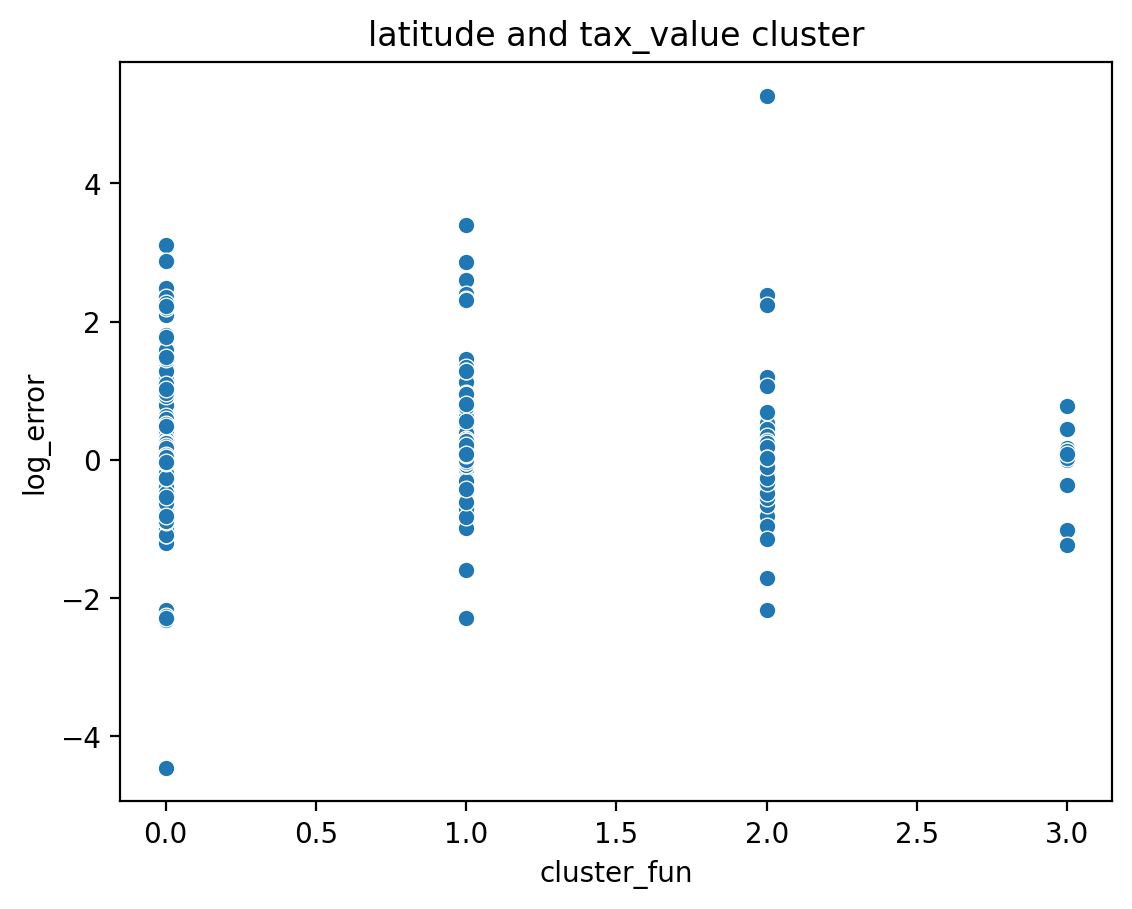

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


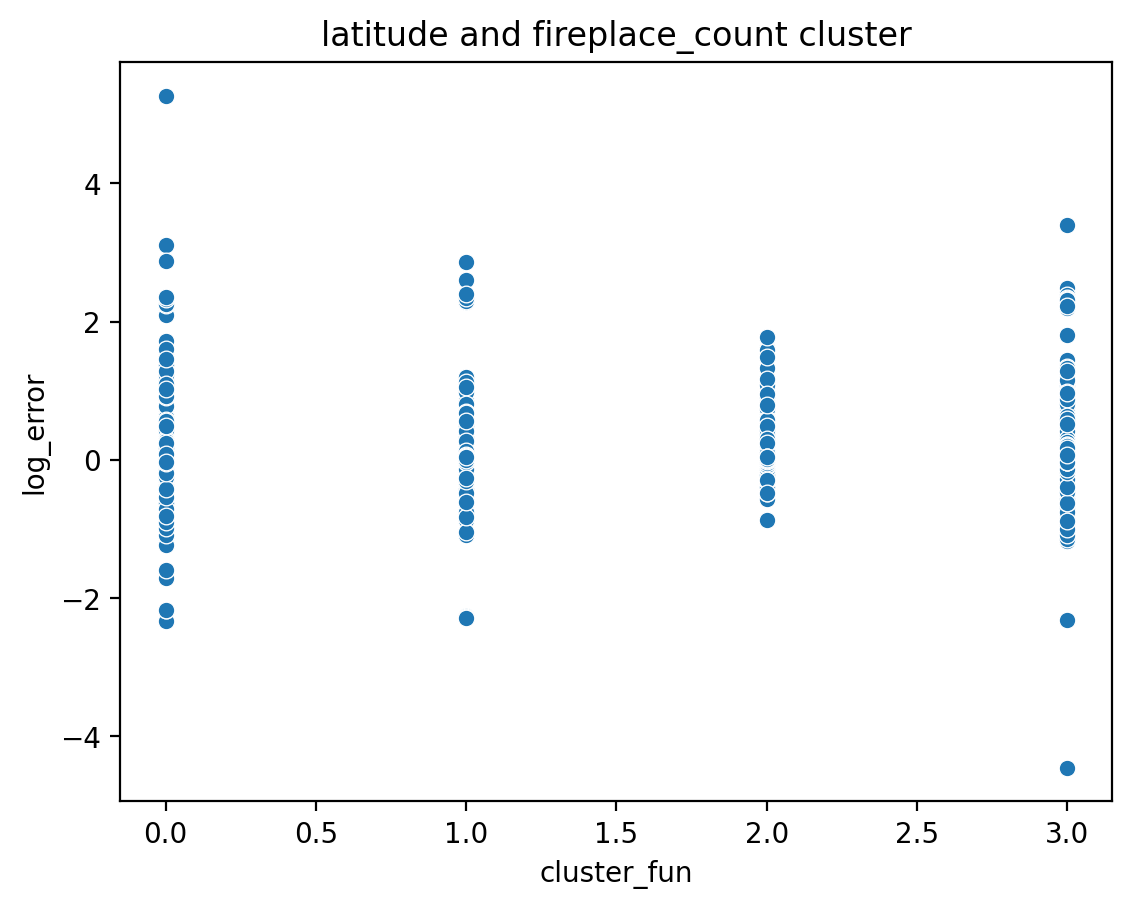

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


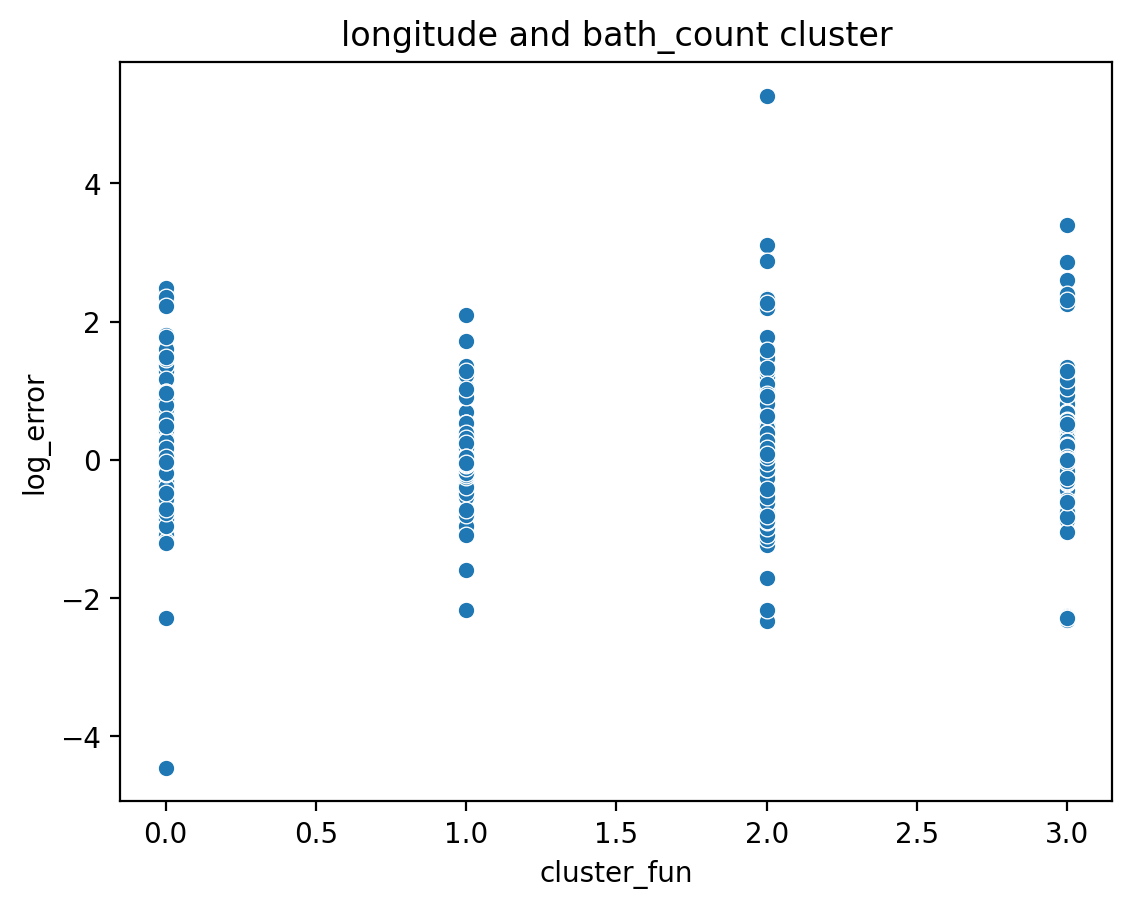

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


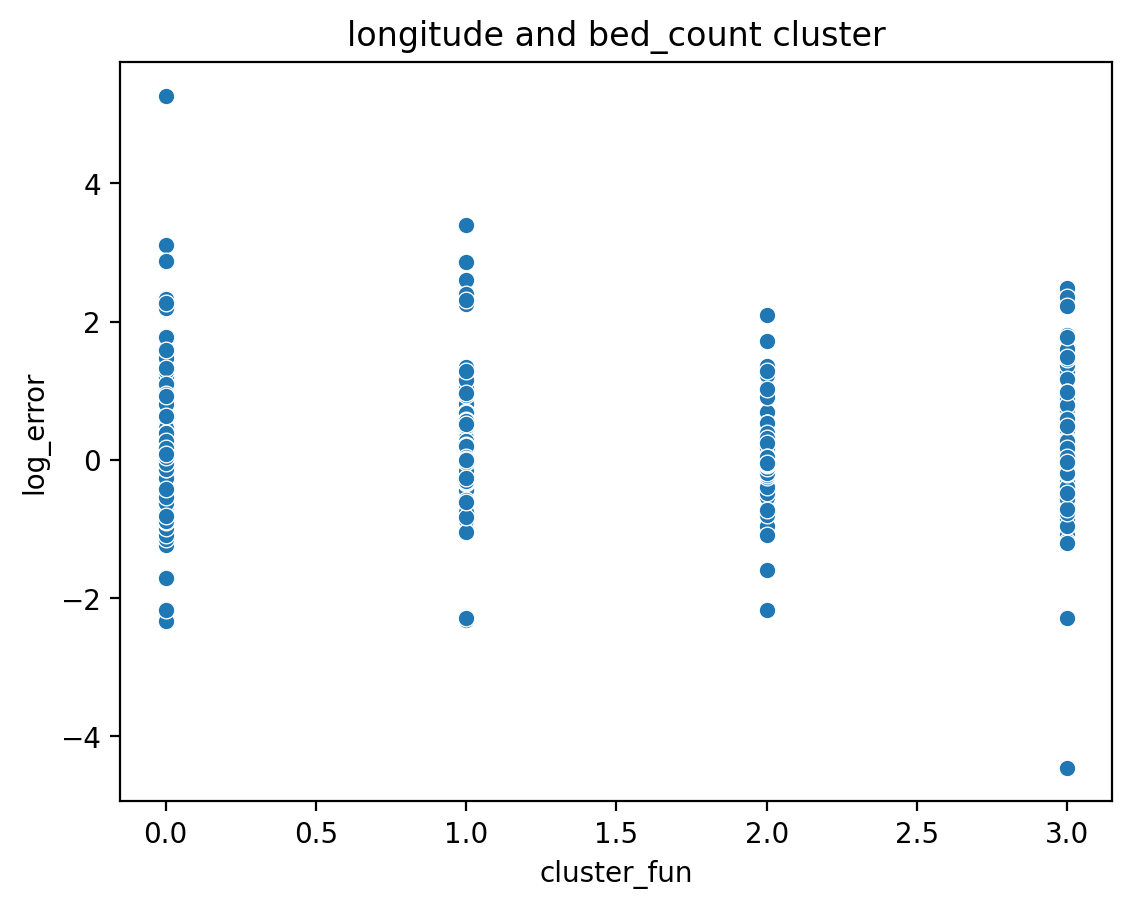

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


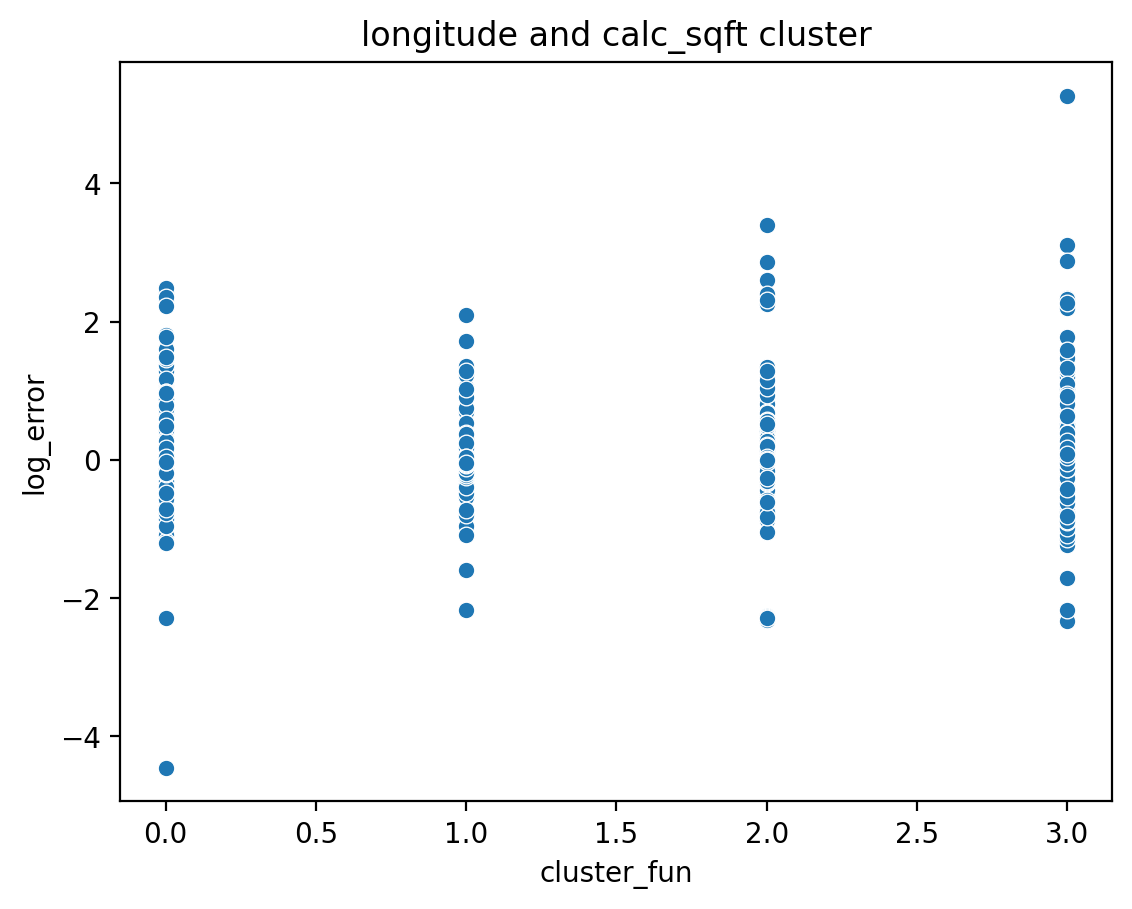

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


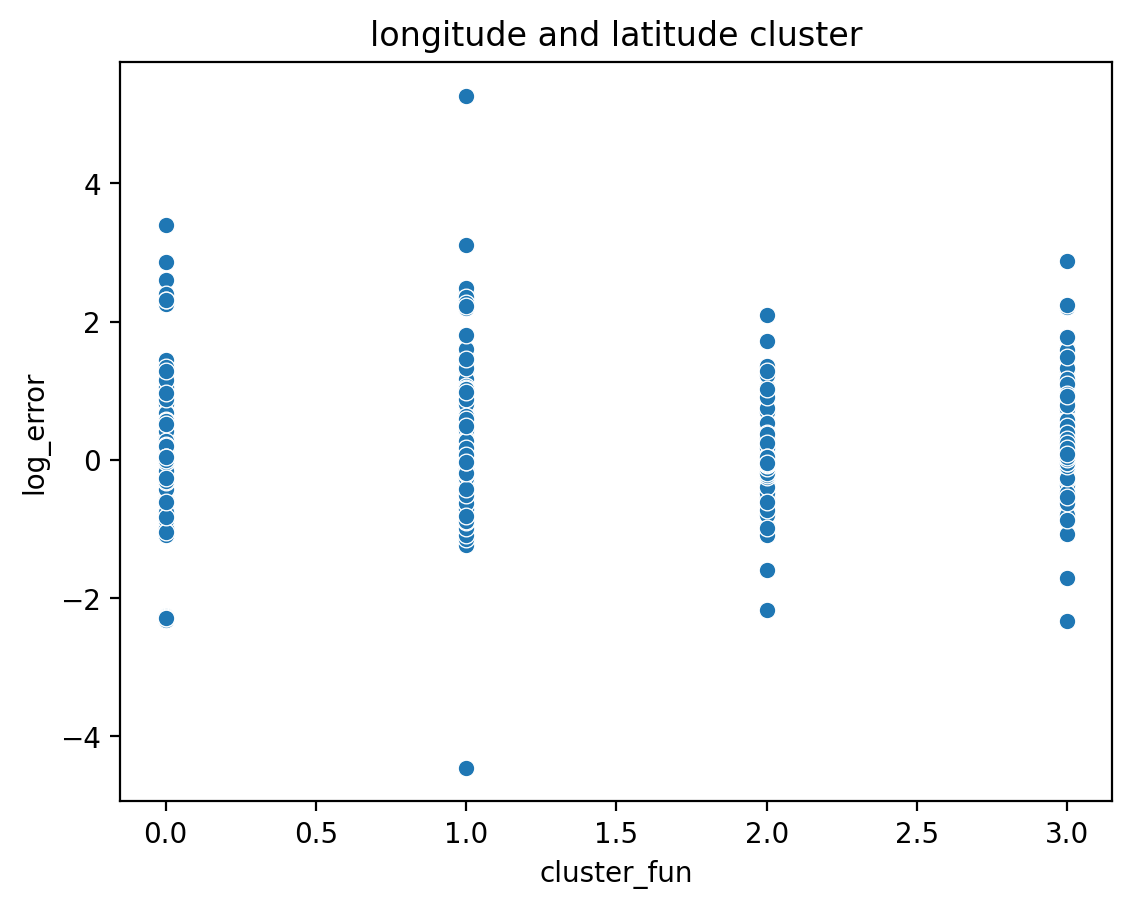

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


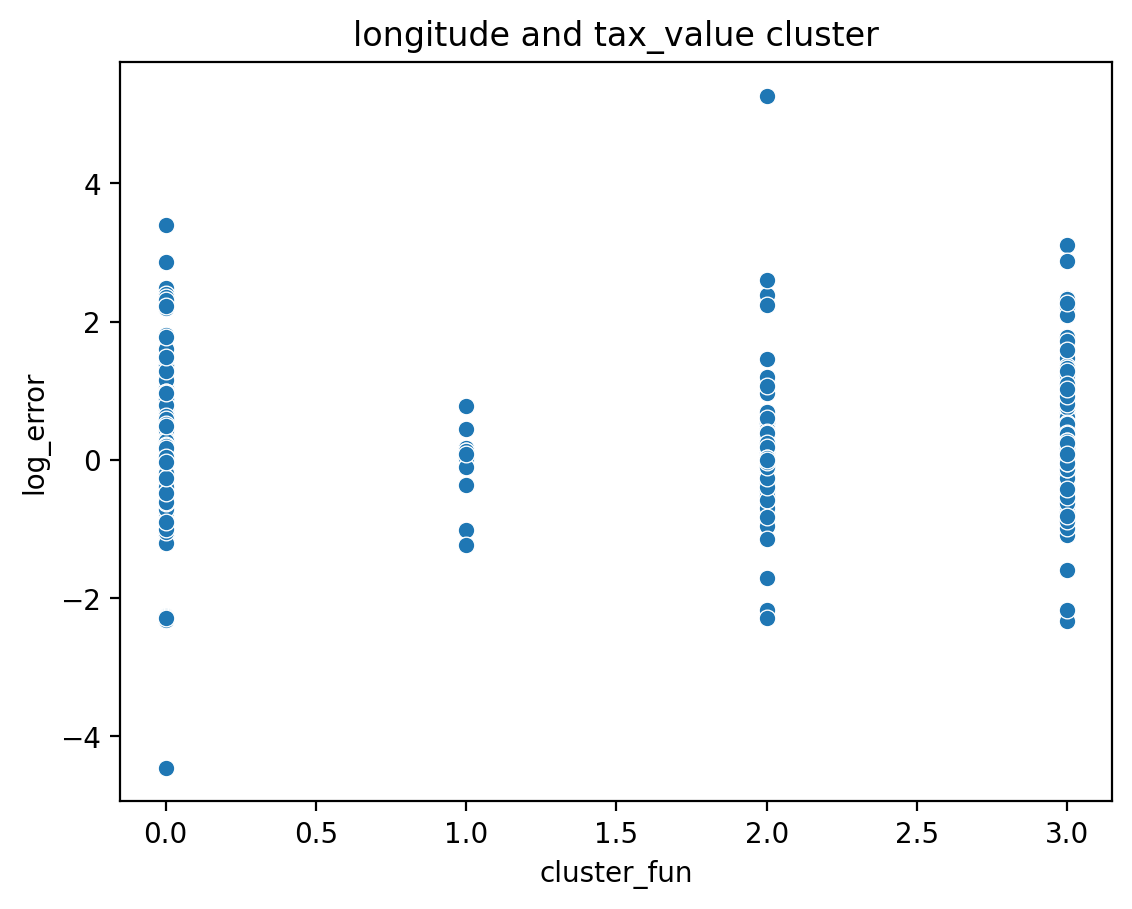

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


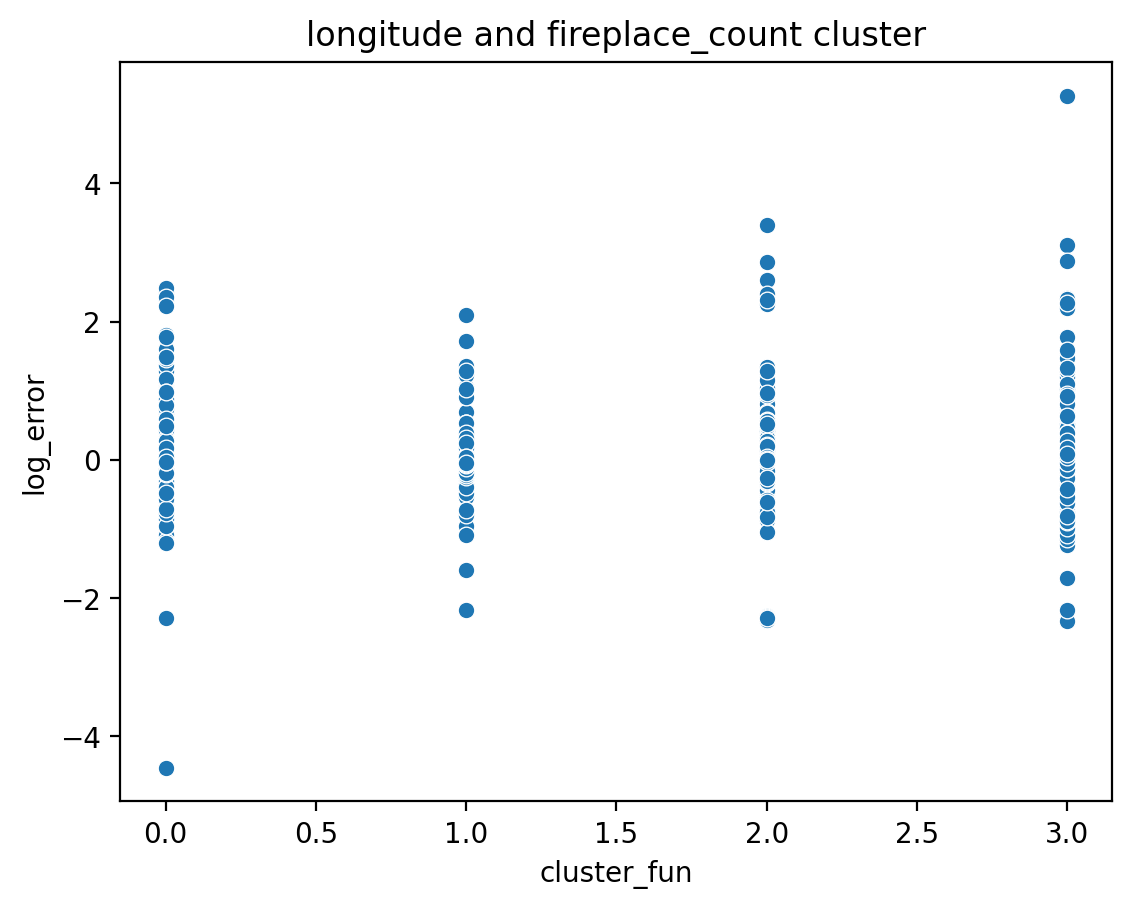

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


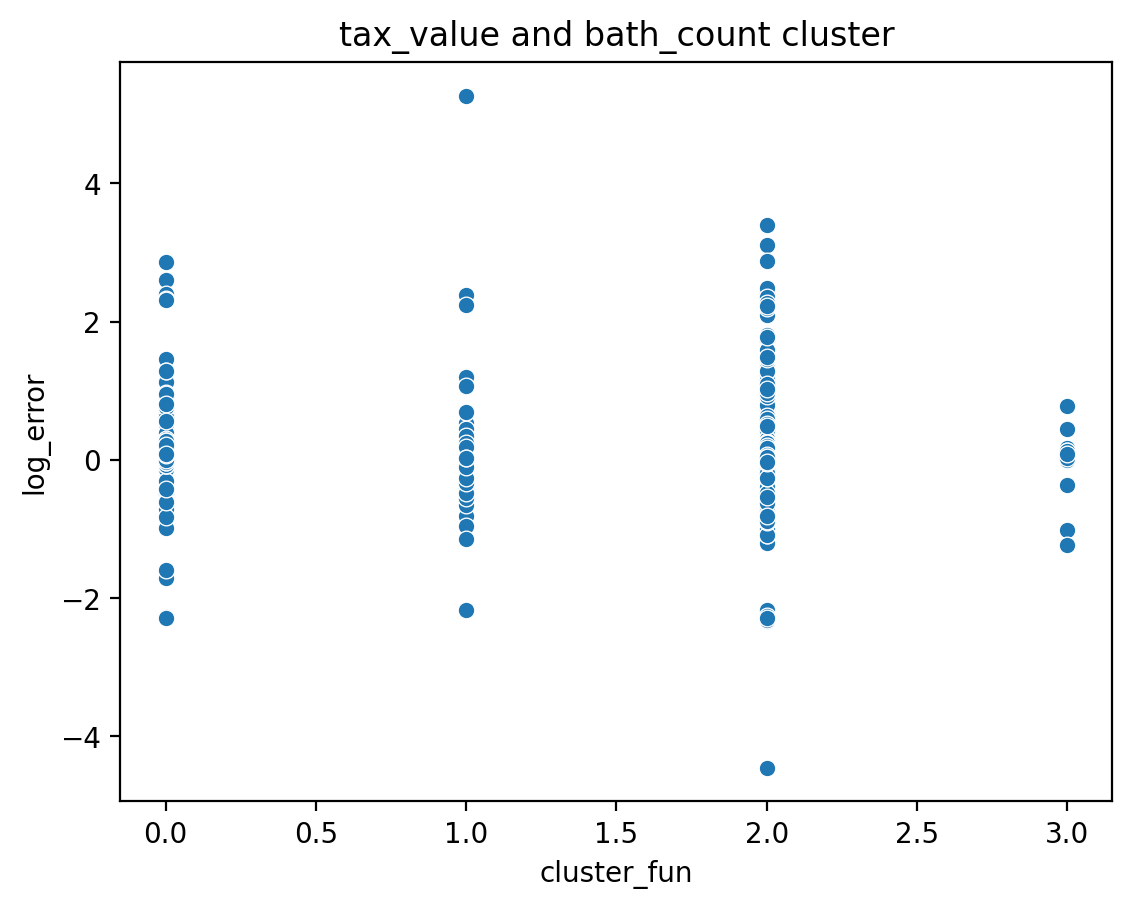

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


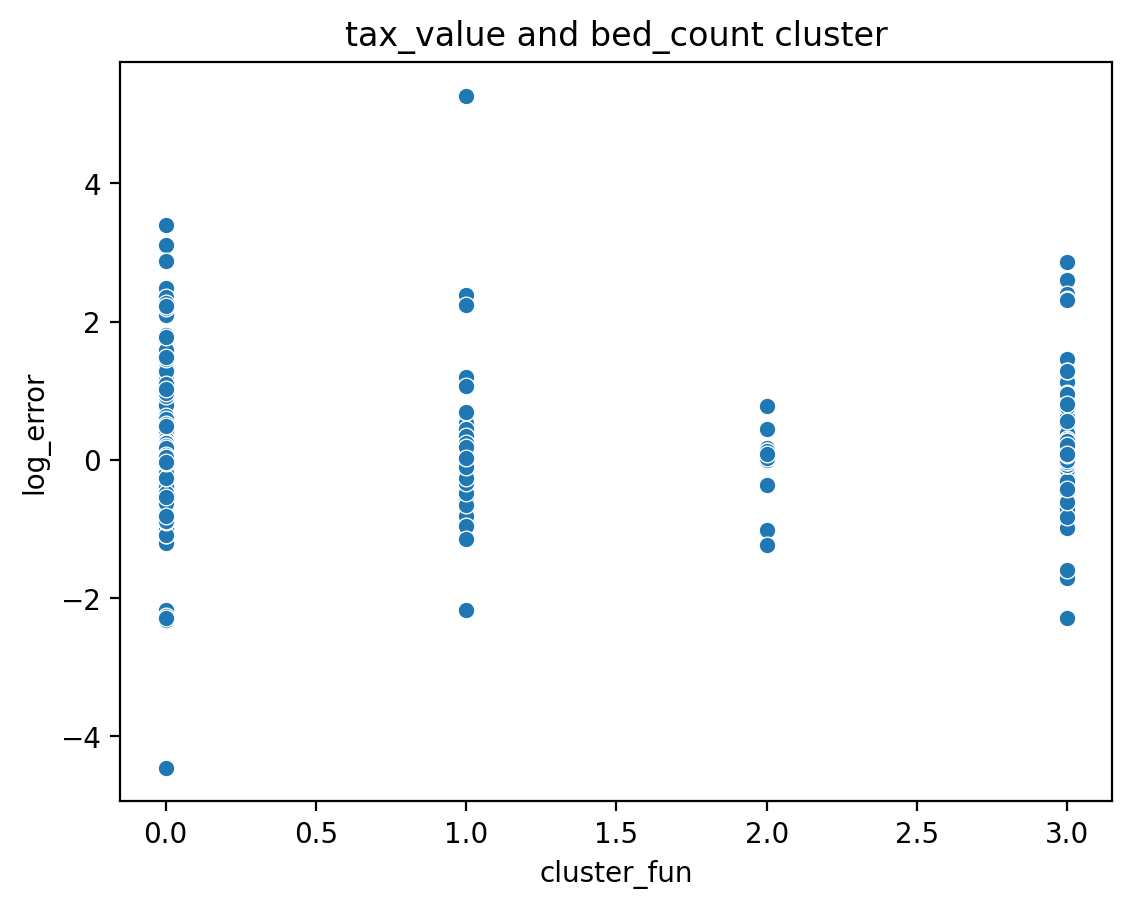

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


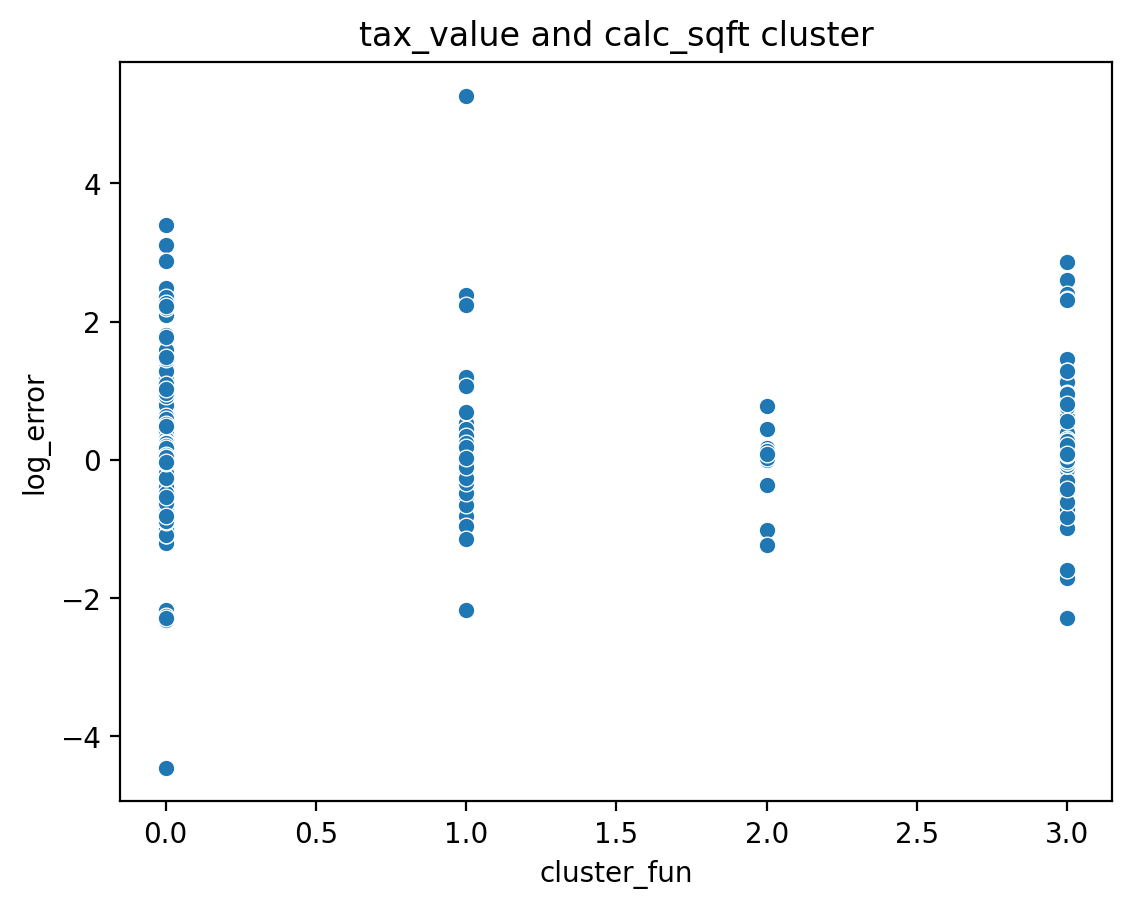

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


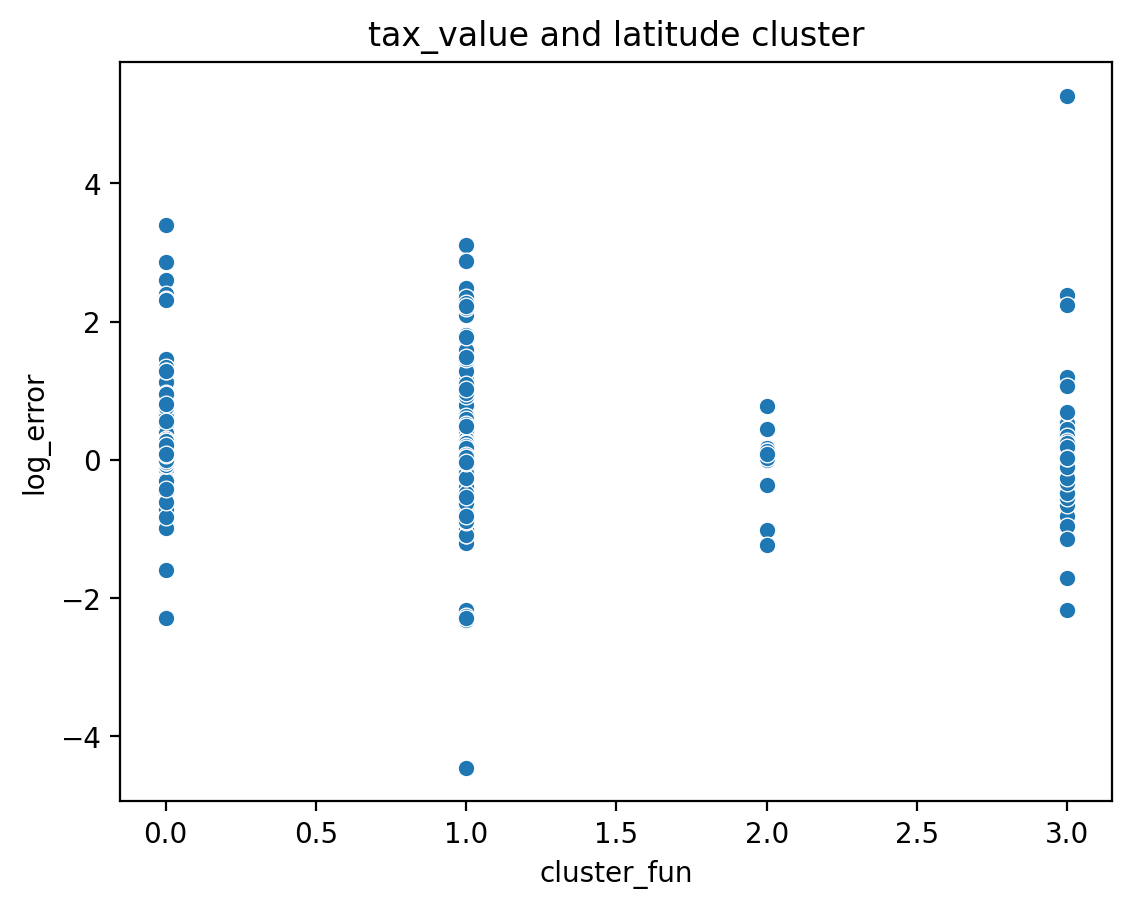

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


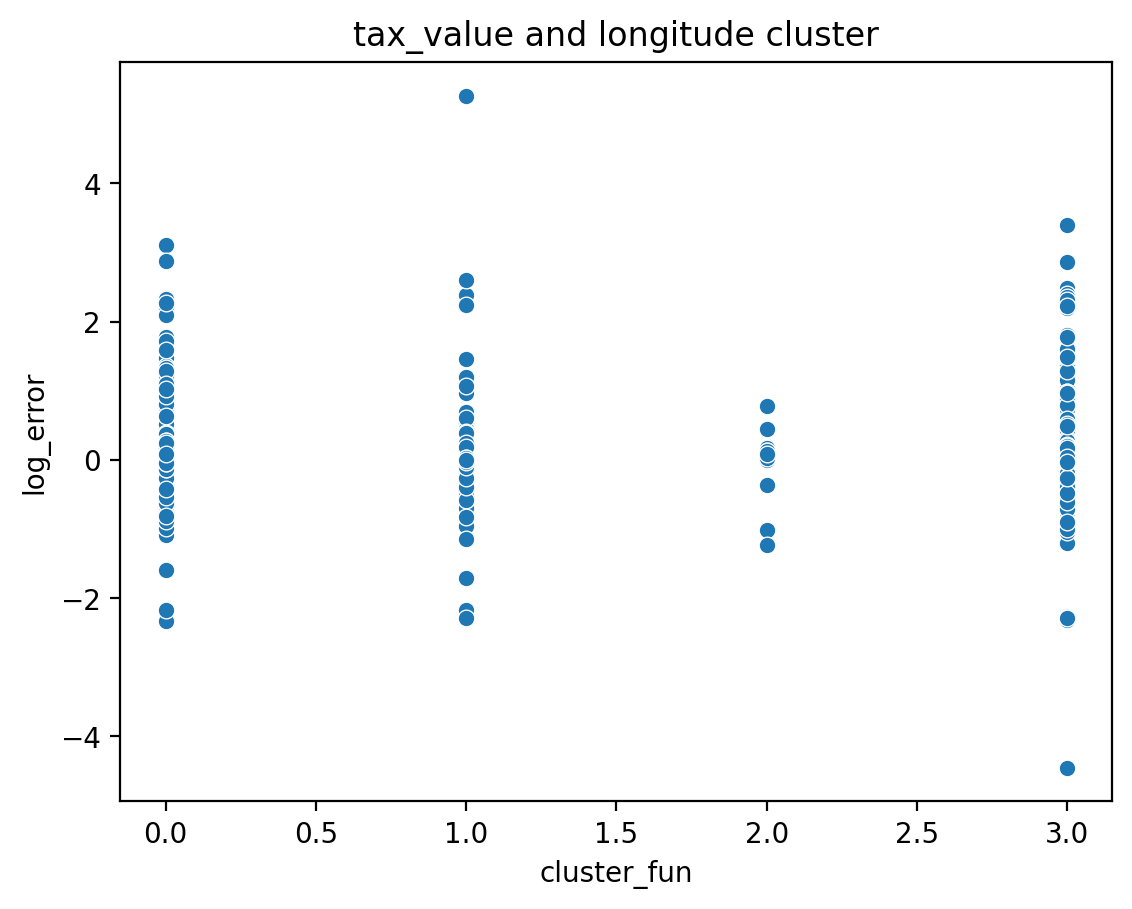

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


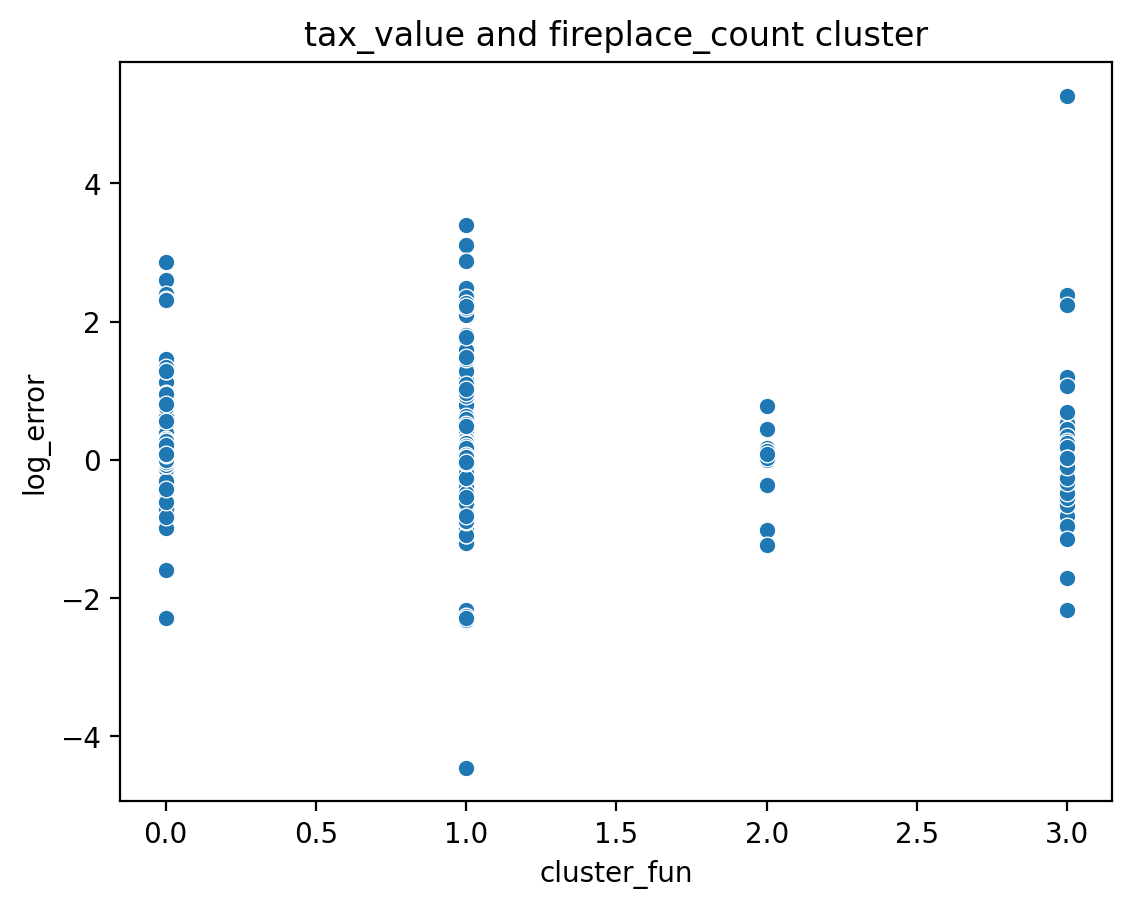

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


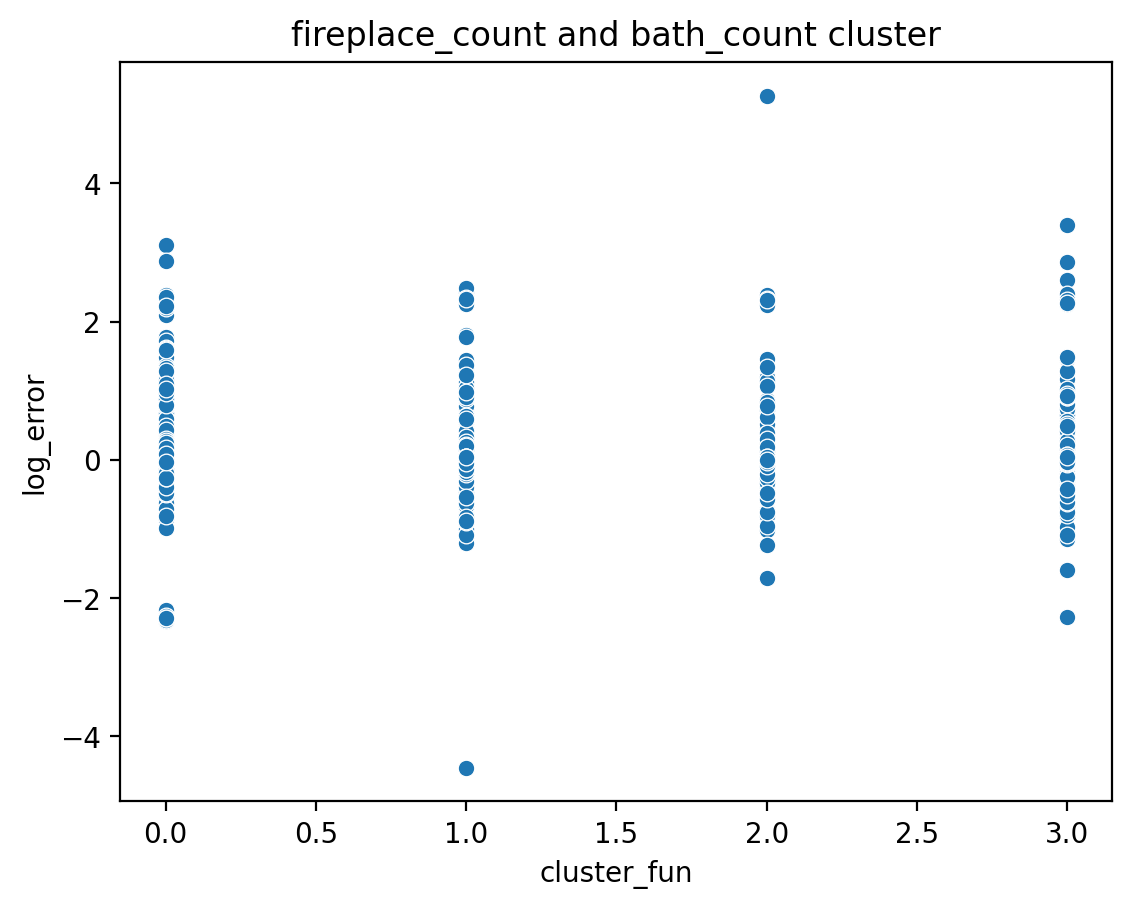

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


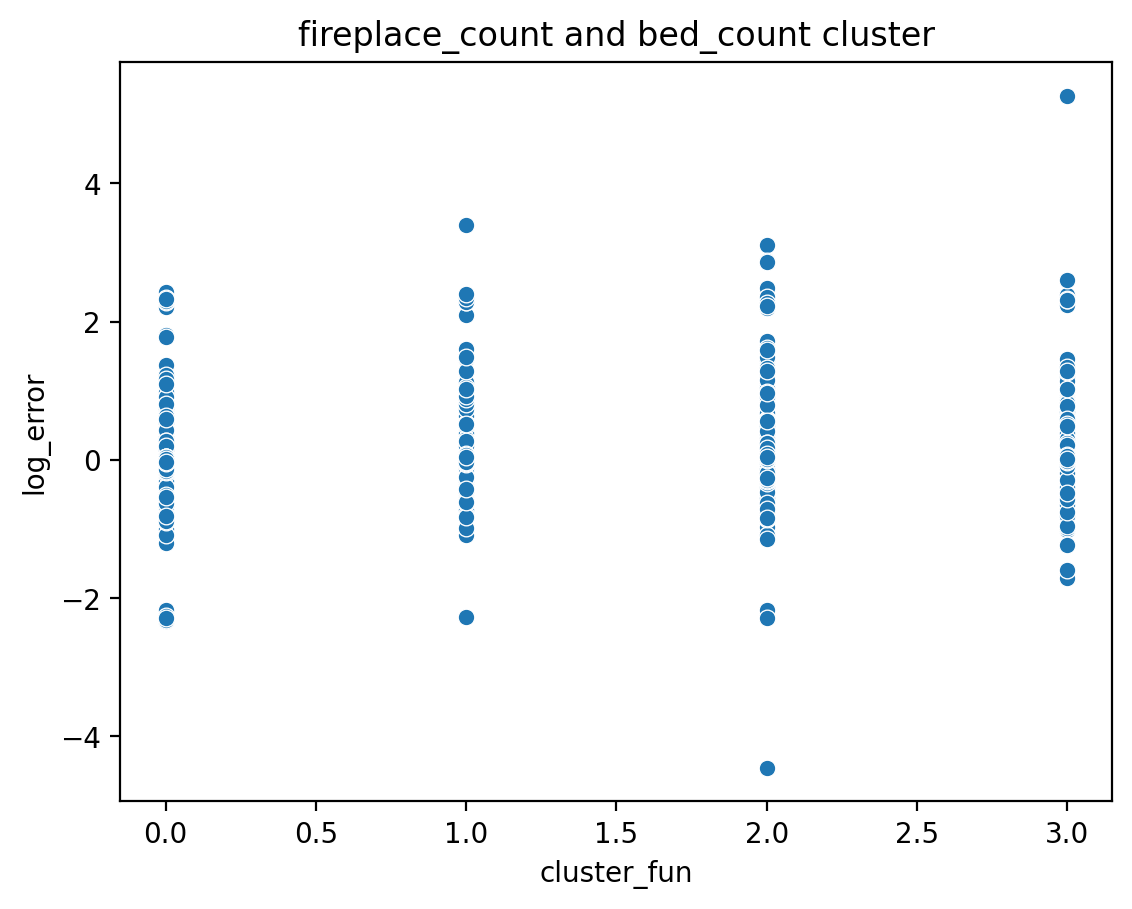

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


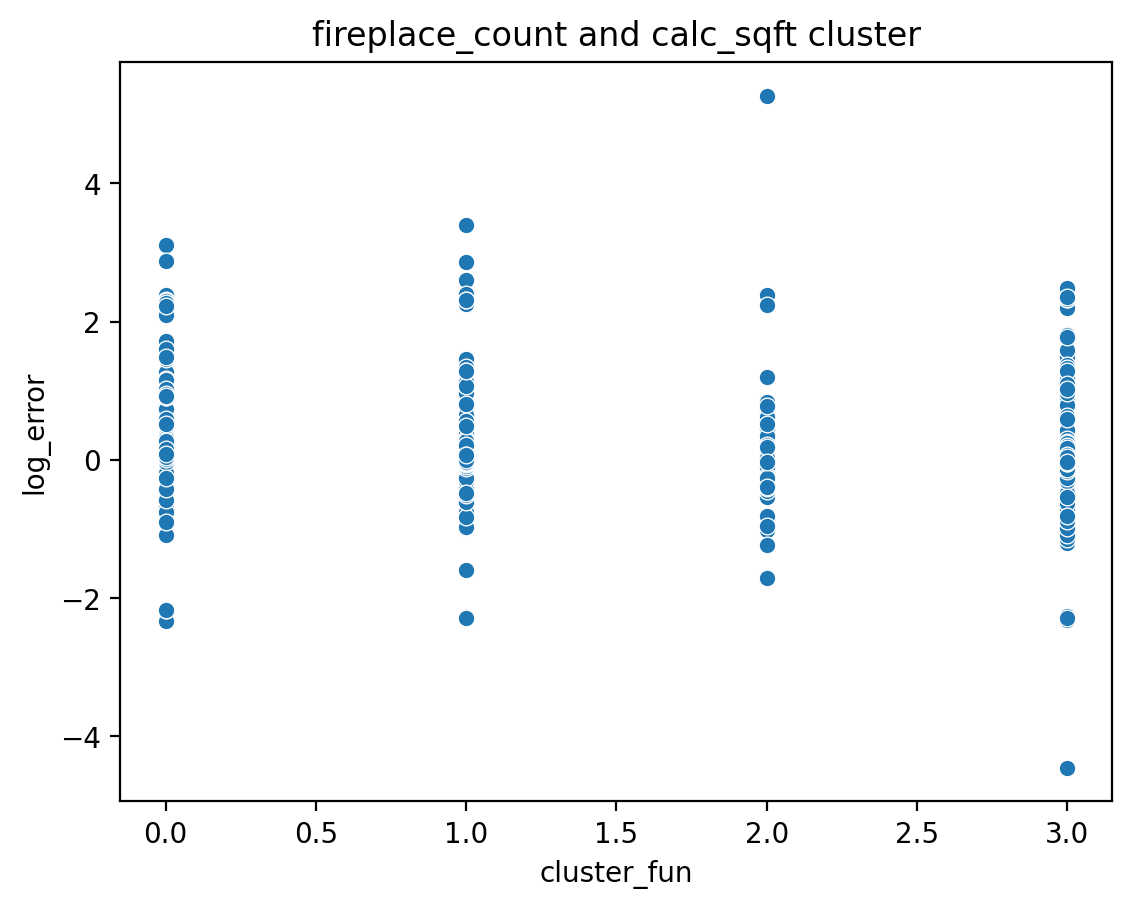

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


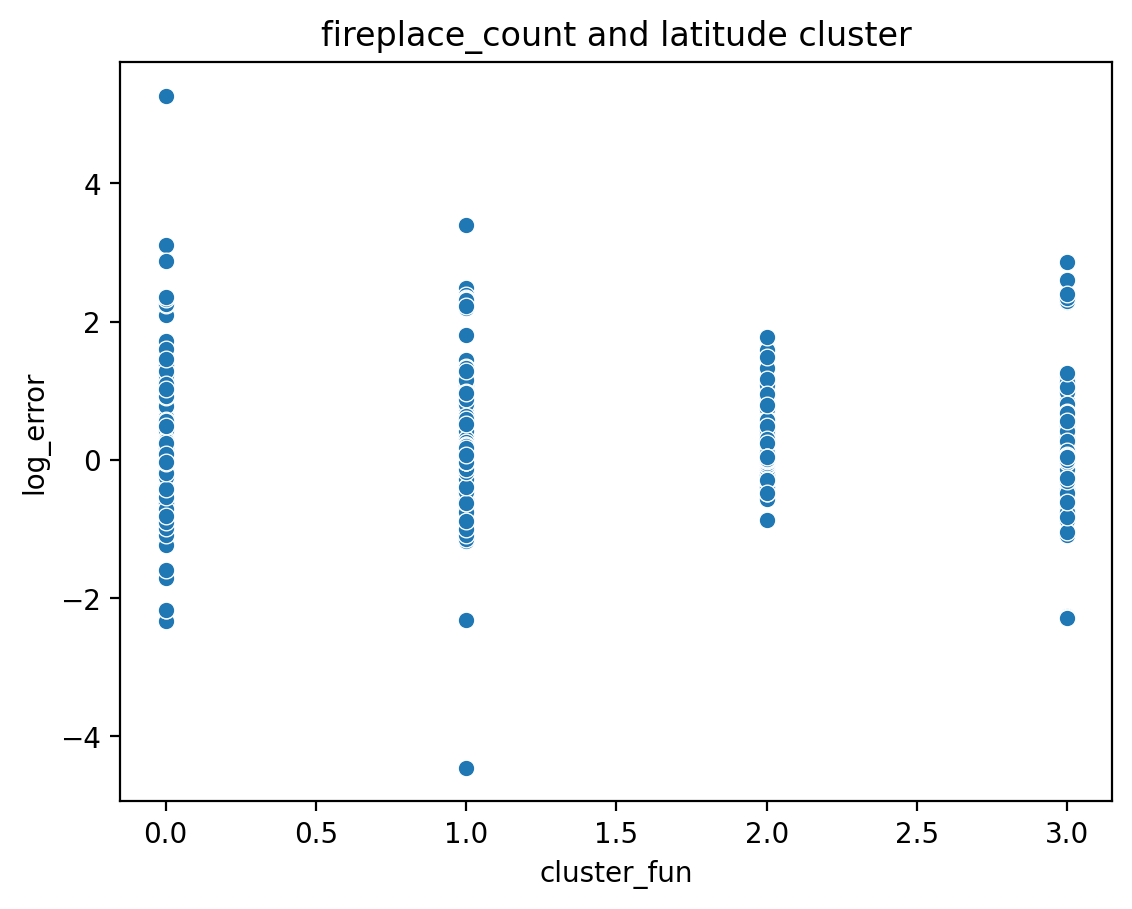

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


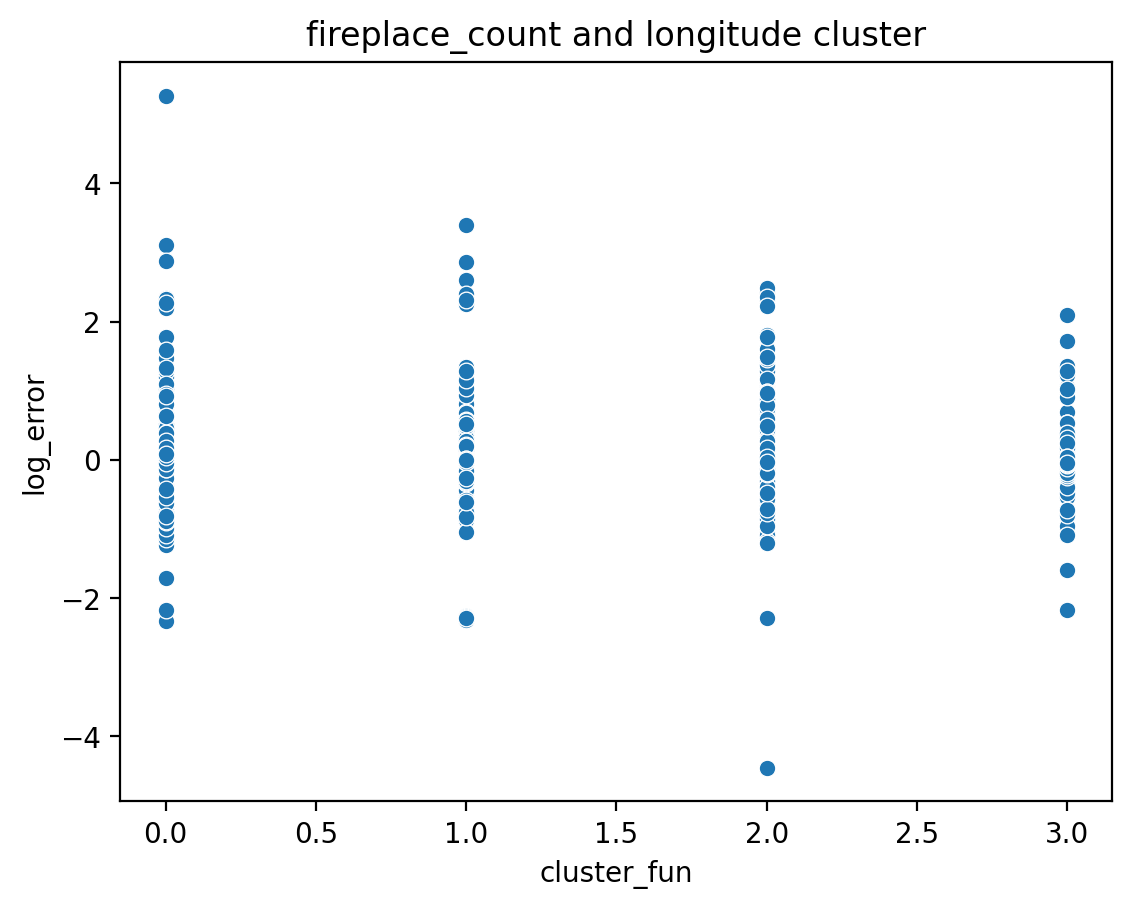

/var/folders/_2/qgk9bxgs6tb0znx9dhfqhplw0000gn/T/ipykernel_23237/3692140331.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='log_error', x='cluster_fun',


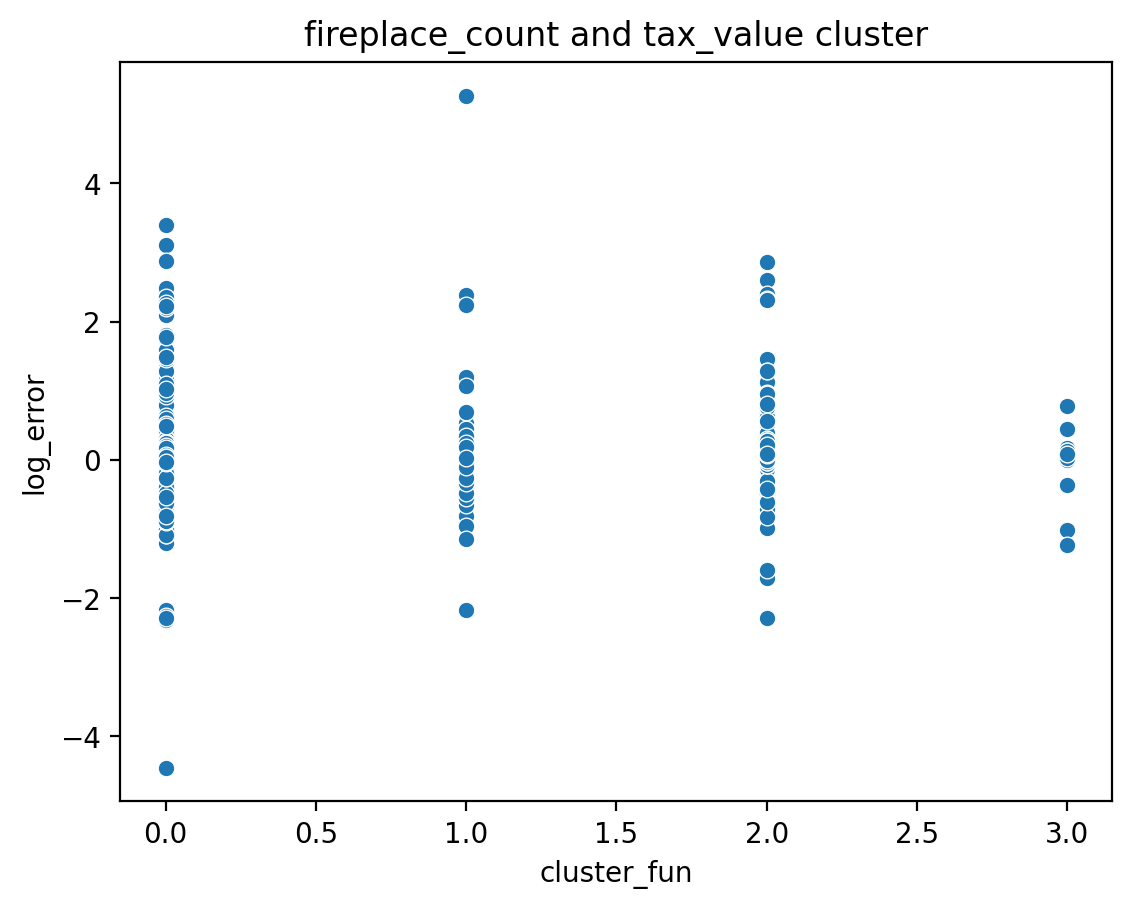

In [35]:
for feature in all_features:
    for feature2 in all_features:
        if feature != feature2: 
            cluster_fun = cluster_test[[feature, feature2]]

            #Fit a new model to my scaled data
            kmeans_scale = KMeans(n_clusters=4)

            kmeans_scale.fit(cluster_fun)

            cluster_test['cluster_fun'] = kmeans_scale.predict(cluster_fun)
            plt.title(f'{feature} and {feature2} cluster')
            sns.scatterplot(y='log_error', x='cluster_fun',
                    palette='colorblind', data=cluster_test)
            plt.show()

In [ ]:
train.info()